## Eligibility for mobilization - Analysis

Run this script after running the [cohort_identification.ipynb](cohort_identification.ipynb)

## Load libraries 

In [1]:
#! pip install pandas numpy duckdb seaborn matplotlib tableone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import pyCLIF

from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

Loaded configuration from config.json


In [2]:
final_df = pd.read_parquet('../output/intermediate/final_df.parquet')
vent_start_end = pd.read_parquet('../output/intermediate/final_block_vent_start_end_dttms.parquet')
all_ids_w_outcome = pd.read_csv('../output/intermediate/cohort_all_ids_w_outcome.csv')

## Forward and Backward fill the final dataset

In [3]:
# 1) Define which columns are flags vs. which are “excluded” vs. which need numeric ffill
flag_columns = [
    'hourly_trach','hourly_on_vent','nicardipine_flag','nitroprusside_flag',
    'clevidipine_flag','red_meds_flag','cisatracurium_flag','vecuronium_flag',
    'rocuronium_flag','paralytics_flag'
]
exclude_columns = [
    'patient_id','hospitalization_id','encounter_block',
    'recorded_dttm','recorded_date','recorded_hour',
    'time_from_vent','time_from_vent_adjusted'
]
all_cols = set(final_df.columns)
potential_fill_cols = all_cols - set(flag_columns) - set(exclude_columns)
# Keep only columns that are numeric
continuous_columns = [c for c in potential_fill_cols if pd.api.types.is_numeric_dtype(final_df[c])]

# 2) Fill flags with 0
for col in flag_columns:
    final_df[col] = final_df[col].fillna(0).astype(int)

# 3) Forward/Backward fill continuous columns
final_df[continuous_columns] = (
    final_df.groupby('encounter_block')[continuous_columns]
    .transform(lambda s: s.ffill().bfill())
)

# 4 Handle trach- once on trach, assume they will continue to be on trach for the rest of their stay
final_df['hourly_trach'] = (
    final_df.groupby('encounter_block')['hourly_trach']
    .transform(lambda s: s.cummax())
    .astype(int)
)

In [4]:
# checkpoint- useful to compare to the original df and check filling logic
final_df.to_parquet(f'../output/intermediate/final_df_filled_{datetime.now().date()}.parquet')

## Create Criteria Flags

### Patel et al. Criteria:

Cardio
* Mean arterial blood pressure: 65-110 mm Hg
* Systolic blood pressure: ≤ 200 mm Hg
* Heart rate: 40-130 beats per minute

Respiratory
* Respiratory rate: 5-40 breaths per minute
* Pulse oximetry: ≥ 88%

In [5]:
# Apply Patel et al. Criteria

# 1. Mean arterial blood pressure: 65-110 mm Hg
final_df['patel_map_flag'] = (
    (final_df['min_map'] >= 65) & (final_df['max_map'] <= 110)
).astype(int)

# 2. Systolic blood pressure: ≤ 200 mm Hg
final_df['patel_sbp_flag'] = (
    final_df['max_sbp'] <= 200
).astype(int)

# 3. Heart rate (Pulse): 40-130 beats per minute
final_df['patel_pulse_flag'] = (
    (final_df['min_heart_rate'] >= 40) & (final_df['max_heart_rate'] <= 130)
).astype(int)

# 4. Respiratory rate: 5-40 breaths per minute
final_df['patel_resp_rate_flag'] = (
    (final_df['min_respiratory_rate'] >= 5) & (final_df['max_respiratory_rate'] <= 40)
).astype(int)

# 5. Pulse oximetry (SpO2): ≥ 88%
final_df['patel_spo2_flag'] = (
    final_df['min_spo2'] >= 88
).astype(int)

# Resp flag: Combines respiratory rate and SpO2 criteria
final_df['patel_resp_flag'] = (
    final_df['patel_resp_rate_flag'] &
    final_df['patel_spo2_flag'] &
    (final_df['hourly_trach'] == 0) &
    (final_df['paralytics_flag'] == 0)
).astype(int)

# Cardio flag: Combines MAP, SBP, and Pulse criteria
final_df['patel_cardio_flag'] = (
    final_df['patel_map_flag'] &
    final_df['patel_sbp_flag'] &
    final_df['patel_pulse_flag'] &
    (final_df['hourly_trach'] == 0) &
    (final_df['paralytics_flag'] == 0)
).astype(int)

# Step 2: Create the overall Patel flag
final_df['patel_flag'] = (
    final_df['patel_map_flag'] &
    final_df['patel_sbp_flag'] &
    final_df['patel_pulse_flag'] &
    final_df['patel_resp_rate_flag'] &
    final_df['patel_spo2_flag'] &
    (final_df['hourly_trach'] == 0) &
    (final_df['paralytics_flag'] == 0) &
    (final_df['recorded_hour'] >= 8) &
    (final_df['recorded_hour'] < 17)
)

### TEAM criteria

Cardio
* Heart rate: ≤ 150 bpm
* Most recent lactate: ≤ 4.0 mmol/L
* Noradrenaline infusion rate: <0.2 mcg/kg/min or if infusion rate has increased by more than 25% in the last 6 hours, dose must be <0.1 mcg/kg/min.
Respiratory
* Sufficient respiratory stability:
    *  FiO2: ≤ 0.6
    *  PEEP: ≤ 16 cm H2O (use peep_observed)
* Current respiratory rate: ≤ 45 (use resp_rate_obs)

In [6]:
# 1. Heart rate: ≤ 150 bpm
final_df['team_pulse_flag'] = (
    final_df['max_heart_rate'] <= 150
).astype(int)

# 2. Most recent lactate: ≤ 4.0 mmol/L
final_df['team_lactate_flag'] = (
    final_df['lactate'] <= 4.0
).astype(int)

# 3. Noradrenaline infusion rate: <0.2 mcg/kg/min 
final_df['team_ne_flag'] = (
    # (final_df['ne_calc_min'] >= 0.1) & (final_df['ne_calc_max'] <= 0.2)
    final_df['ne_calc_max'] <= 0.2
).astype(int)

# print the number of team_ne_flag == 1
print("TEAM NE flag counts when ne < 0.2\n", final_df['team_ne_flag'].value_counts(), "\n")
 
#3b. set the flag to 0 if infusion rate has increased by more than 25% in the last 6 hours and the dose is >0.1 mcg/kg/min.
final_df['team_ne_flag'] = np.where(
    (final_df['ne_calc_max'] > 1.25 * final_df['min_ne_dose_last_6_hours']) & (final_df['ne_calc_max'] > 0.1),
    0,
    final_df['team_ne_flag']
)
print("TEAM NE flag counts adjusting for change in the last 6 hrs\n", final_df['team_ne_flag'].value_counts(), "\n")

# 4. Sufficient respiratory stability:
#    a. FiO2: ≤ 0.6
final_df['team_fio2_flag'] = (
    final_df['min_fio2_set'] <= 0.6
).astype(int)

#    b. PEEP: ≤ 16 cm H2O
final_df['team_peep_flag'] = (
    final_df['max_peep_set'] <= 16
).astype(int)

# 5. Current respiratory rate: ≤ 45
final_df['team_resp_rate_flag'] = (
    final_df['max_resp_rate_obs'] <= 45 
).astype(int)

# Cardio flag: Combines heart rate, lactate, and norepinephrine criteria
final_df['team_cardio_flag'] = (
    final_df['team_pulse_flag'] &
    final_df['team_lactate_flag'] &
    final_df['team_ne_flag'] &
    (final_df['hourly_trach'] == 0) &
    (final_df['paralytics_flag'] == 0)
).astype(int)

# Resp flag: Combines FiO2, PEEP, and respiratory rate criteria
final_df['team_resp_flag'] = (
    final_df['team_fio2_flag'] &
    final_df['team_peep_flag'] &
    final_df['team_resp_rate_flag'] &
    (final_df['hourly_trach'] == 0) &
    (final_df['paralytics_flag'] == 0)
).astype(int)


# Create the overall TEAM flag
final_df['team_flag'] = (
    final_df['team_pulse_flag'] &
    final_df['team_lactate_flag'] &
    final_df['team_ne_flag'] &
    final_df['team_fio2_flag'] &
    final_df['team_peep_flag'] &
    final_df['team_resp_rate_flag'] &
    (final_df['hourly_trach'] == 0) &
    (final_df['paralytics_flag'] == 0) & 
    (final_df['recorded_hour'] >= 8) &
    (final_df['recorded_hour'] < 17)
)

TEAM NE flag counts when ne < 0.2
 team_ne_flag
1    1043499
0     523148
Name: count, dtype: int64 

TEAM NE flag counts adjusting for change in the last 6 hrs
 team_ne_flag
1    980917
0    585730
Name: count, dtype: int64 



### Consensus criteria

* Green Criteria
    * Respiratory
        * Saturation  90% and
        * Respiratory rate ≤ 30 breaths/min
        * Current FiO2 ≤ 0.6 and
        * PEEP≤ 10cm H20
    * Cardiovascular:
        * Blood pressure greater than lower limit of target range (MAP 65+) while on no or low level of support (low support- define as <0.1 μg/kg/min of Norepi equivalents)
        * Heart rate <120 beats/min
        * lactate < 4mmol/L
        * HR > 40
* Yellow Criteria
    * Respiratory
        * Sat >= 90%
        * Current FiO2 >0.6
        * Respiratory rate >30breaths/min
        * PEEP >10cm H20
    * Cardiovascular
        * Blood pressure greater than lower limit of target range (MAP 65+) while receiving moderate level of support (medium-define as 0.1–0.3 μg/kg/min of Norepi equivalents)
        * Heart rate 120-150 beats/min
        * Shock of any cause with lactate >4mmol/L
        * HR > 40
* Red Criteria
    * Respiratory
        * Sat <90%
    * Cardiovascular
        * Below target MAP despite support (MAP <65) or
        * greater than lower limit MAP (MAP 65+) but on high level support (high defined as >0.3 μg/kg/min of Norepi equivalents)
        * IV therapy for hypertensive emergency (SBP >200mmHg or MAP >110 and on nicardipine, nitroprusside, or clevidipine gtt)
        * HR >150 bpm
        * Bradycardia <40


### Consensus criteria - redefined 

* all_red: All red subcomponents must be met.
* all_green: All green subcomponents must be met, and no red subcomponents are met.
* all_yellow: All yellow subcomponents must be met, no red subcomponents are met, and all green subcomponents are not met.
* any_yellow: Any yellow subcomponent is met, no green subcomponents are fully met, and no red subcomponents are met.
* any_yellow_or_green_no_red: Any yellow or green subcomponents are met, but no red subcomponents are met.

In [7]:
# Red Cardiovascular Criteria
final_df['red_resp_spo2_flag'] = (final_df['min_spo2'] < 90).astype(int)
final_df['red_map_flag'] = (final_df['min_map'] < 65).astype(int)
# High support (Norepinephrine equivalents > 0.3 μg/kg/min)
final_df['red_high_support_flag'] = (final_df['ne_calc_max'] > 0.3).astype(int)
# Hypertensive emergency criteria (SBP > 200 mmHg or MAP > 110 mmHg and on certain medications)
final_df['red_hypertensive_flag'] = (
    ((final_df['max_sbp'] > 200) | (final_df['max_map'] > 110)) &
    (final_df['red_meds_flag'] == 1)
).astype(int)
# High heart rate criteria (HR > 150 bpm)
final_df['red_pulse_high_flag'] = (final_df['max_heart_rate'] > 150).astype(int)
# Low heart rate criteria (HR < 40 bpm)
final_df['red_pulse_low_flag'] = (final_df['min_heart_rate'] < 40).astype(int)

# Yellow Respiratory Criteria
final_df['yellow_resp_spo2_flag'] = (final_df['min_spo2'] >= 90).astype(int)
final_df['yellow_fio2_flag'] = (final_df['min_fio2_set'] > 0.6).astype(int)
final_df['yellow_resp_rate_flag'] = (final_df['max_resp_rate_obs'] > 30).astype(int)
final_df['yellow_peep_flag'] = (final_df['min_peep_set'] > 10).astype(int)

# Yellow Cardiovascular Criteria
final_df['yellow_map_flag'] = ((final_df['min_map'] >= 65) & (final_df['ne_calc_max'].between(0.1, 0.3))).astype(int)
final_df['yellow_pulse_flag'] = (final_df['min_heart_rate'].between(120, 150)).astype(int)
final_df['yellow_lactate_flag'] = (final_df['lactate'] > 4).astype(int)

# Step 3: Implement Green Criteria
final_df['green_resp_spo2_flag'] = (final_df['min_spo2'] >= 90).astype(int)
final_df['green_resp_rate_flag'] = (final_df['max_resp_rate_obs'] <= 30).astype(int)
final_df['green_fio2_flag'] = (final_df['min_fio2_set'] <= 0.6).astype(int)
final_df['green_peep_flag'] = (final_df['min_peep_set'] <= 10).astype(int)

# Green Cardiovascular Criteria
final_df['green_map_flag'] = ((final_df['min_map'] >= 65) & (final_df['ne_calc_max'] < 0.1)).astype(int)
final_df['green_pulse_flag'] = (final_df['min_heart_rate'] < 120).astype(int)
final_df['green_lactate_flag'] = (final_df['lactate'] < 4).astype(int)
final_df['green_hr_flag'] = (final_df['min_heart_rate'] > 40).astype(int)

final_df['any_red'] = (
    (final_df['red_resp_spo2_flag'] |
    final_df['red_map_flag'] |
    final_df['red_high_support_flag'] |
    final_df['red_hypertensive_flag'] |
    final_df['red_pulse_high_flag'] |
    final_df['red_pulse_low_flag']) &
    (final_df['hourly_trach'] == 0) &
    (final_df['paralytics_flag'] == 0) &
    (final_df['recorded_hour'] >= 8) &
    (final_df['recorded_hour'] < 17)
).astype(int)

final_df['any_yellow'] = (
    (final_df['yellow_resp_spo2_flag'] |
    final_df['yellow_fio2_flag'] |
    final_df['yellow_resp_rate_flag'] |
    final_df['yellow_peep_flag'] |
    final_df['yellow_map_flag'] |
    final_df['yellow_pulse_flag'] |
    final_df['yellow_lactate_flag']) &
    (final_df['hourly_trach'] == 0) &
    (final_df['paralytics_flag'] == 0) &
    (final_df['recorded_hour'] >= 8) &
    (final_df['recorded_hour'] < 17)
).astype(int)

final_df['any_green'] = (
    (final_df['green_resp_spo2_flag'] |
    final_df['green_resp_rate_flag'] |
    final_df['green_fio2_flag'] |
    final_df['green_peep_flag'] |
    final_df['green_map_flag'] |
    final_df['green_pulse_flag'] |
    final_df['green_lactate_flag'] |
    final_df['green_hr_flag']) &
    (final_df['hourly_trach'] == 0) &
    (final_df['paralytics_flag'] == 0) &
    (final_df['recorded_hour'] >= 8) &
    (final_df['recorded_hour'] < 17)
).astype(int)

final_df['all_green'] = (
    final_df['green_resp_spo2_flag'] &
    final_df['green_resp_rate_flag'] &
    final_df['green_fio2_flag'] &
    final_df['green_peep_flag'] &
    final_df['green_map_flag'] &
    final_df['green_pulse_flag'] &
    final_df['green_lactate_flag'] &
    final_df['green_hr_flag'] &
    (final_df['hourly_trach'] == 0) &
    (final_df['paralytics_flag'] == 0) &
    (final_df['recorded_hour'] >= 8) &
    (final_df['recorded_hour'] < 17)
).astype(int)

final_df['all_green_no_red'] = (
    final_df['green_resp_spo2_flag'] &
    final_df['green_resp_rate_flag'] &
    final_df['green_fio2_flag'] &
    final_df['green_peep_flag'] &
    final_df['green_map_flag'] &
    final_df['green_pulse_flag'] &
    final_df['green_lactate_flag'] &
    final_df['green_hr_flag'] &
    (final_df['any_red'] == 0) &
    (final_df['hourly_trach'] == 0) &
    (final_df['paralytics_flag'] == 0) &
    (final_df['recorded_hour'] >= 8) &
    (final_df['recorded_hour'] < 17)
).astype(int)

final_df['all_green_no_red_yellow'] = (
    final_df['green_resp_spo2_flag'] &
    final_df['green_resp_rate_flag'] &
    final_df['green_fio2_flag'] &
    final_df['green_peep_flag'] &
    final_df['green_map_flag'] &
    final_df['green_pulse_flag'] &
    final_df['green_lactate_flag'] &
    final_df['green_hr_flag'] &
    (final_df['any_red'] == 0) &
    (final_df['any_yellow'] == 0) &
    (final_df['hourly_trach'] == 0) &
    (final_df['paralytics_flag'] == 0) &
    (final_df['recorded_hour'] >= 8) &
    (final_df['recorded_hour'] < 17)
).astype(int)

final_df['all_yellow_no_red_green'] = (
    final_df['yellow_resp_spo2_flag'] &
    final_df['yellow_fio2_flag'] &
    final_df['yellow_resp_rate_flag'] &
    final_df['yellow_peep_flag'] &
    final_df['yellow_map_flag'] &
    final_df['yellow_pulse_flag'] &
    final_df['yellow_lactate_flag'] &
    (final_df['any_red'] == 0) &
    (final_df['any_green'] == 0) &
    (final_df['hourly_trach'] == 0) &
    (final_df['paralytics_flag'] == 0) &
    (final_df['recorded_hour'] >= 8) &
    (final_df['recorded_hour'] < 17)
).astype(int)

final_df['any_yellow_no_red_green'] = (
    (final_df['yellow_resp_spo2_flag'] |
    final_df['yellow_fio2_flag'] |
    final_df['yellow_resp_rate_flag'] |
    final_df['yellow_peep_flag'] |
    final_df['yellow_map_flag'] |
    final_df['yellow_pulse_flag'] |
    final_df['yellow_lactate_flag']) &
    (final_df['any_red'] == 0) &
    (final_df['any_green'] == 0) &
    (final_df['hourly_trach'] == 0) &
    (final_df['paralytics_flag'] == 0) &
    (final_df['recorded_hour'] >= 8) &
    (final_df['recorded_hour'] < 17)
).astype(int)

final_df['any_yellow_or_green_no_red'] = (
    (final_df['yellow_resp_spo2_flag'] |
    final_df['yellow_fio2_flag'] |
    final_df['yellow_resp_rate_flag'] |
    final_df['yellow_peep_flag'] |
    final_df['yellow_map_flag'] |
    final_df['yellow_pulse_flag'] |
    final_df['yellow_lactate_flag'] |
    final_df['green_resp_spo2_flag'] |
    final_df['green_resp_rate_flag'] |
    final_df['green_fio2_flag'] |
    final_df['green_peep_flag'] |
    final_df['green_map_flag'] |
    final_df['green_pulse_flag'] |
    final_df['green_lactate_flag'] |
    final_df['green_hr_flag']) &
    (final_df['any_red'] == 0) &
    (final_df['hourly_trach'] == 0) &
    (final_df['paralytics_flag'] == 0) &
    (final_df['recorded_hour'] >= 8) &
    (final_df['recorded_hour'] < 17)
).astype(int)

final_df['yellow_resp_flag'] = (
    (final_df['yellow_resp_spo2_flag'] |
    final_df['yellow_fio2_flag'] |
    final_df['yellow_resp_rate_flag'] |
    final_df['yellow_peep_flag'] |
    final_df['green_resp_spo2_flag'] |
    final_df['green_resp_rate_flag'] |
    final_df['green_fio2_flag'] |
    final_df['green_peep_flag']) &
    (final_df['any_red'] == 0) &
    (final_df['hourly_trach'] == 0) &
    (final_df['paralytics_flag'] == 0) &
    (final_df['recorded_hour'] >= 8) &
    (final_df['recorded_hour'] < 17)
).astype(int)

final_df['yellow_cardio_flag'] = (
    (final_df['yellow_map_flag'] |
    final_df['yellow_pulse_flag'] |
    final_df['yellow_lactate_flag'] |
    final_df['green_map_flag'] |
    final_df['green_pulse_flag'] |
    final_df['green_lactate_flag'] |
    final_df['green_hr_flag']) &
    (final_df['any_red'] == 0) &
    (final_df['hourly_trach'] == 0) &
    (final_df['paralytics_flag'] == 0) &
    (final_df['recorded_hour'] >= 8) &
    (final_df['recorded_hour'] < 17)
).astype(int)

final_df['yellow_all_green'] = (
    final_df['all_green_no_red'] &
    (final_df['any_yellow'] == 0)
).astype(int)

final_df['yellow_not_all_green'] = (
    final_df['any_yellow_or_green_no_red'] &
    (final_df['all_green_no_red'] == 0)
).astype(int)

In [8]:
# print value counts for each flag
print(final_df[['any_red', 'any_yellow', 'any_green' ,  'all_green',
                'all_green_no_red', 'all_green_no_red_yellow', 'all_yellow_no_red_green', 
                'any_yellow_no_red_green','any_yellow_or_green_no_red','yellow_all_green',
                 'yellow_not_all_green' ]].sum())

any_red                        57226
any_yellow                    473734
any_green                     480236
all_green                     171750
all_green_no_red              171544
all_green_no_red_yellow            0
all_yellow_no_red_green            0
any_yellow_no_red_green            0
any_yellow_or_green_no_red    423010
yellow_all_green                   0
yellow_not_all_green          251466
dtype: int64


## TableOne

In [9]:
table1_overall = pyCLIF.generate_table_one(final_df, filename="table1_overall")
table1_overall


Data loaded successfully from /Users/kavenchhikara/Desktop/CLIF/CLIF-UCMC/rclif/c19/clif_patient.parquet
Data loaded successfully from /Users/kavenchhikara/Desktop/CLIF/CLIF-UCMC/rclif/c19/clif_hospitalization.parquet
Processing DataFrame: patient
No duplicates found based on columns: ['patient_id'].
Processing DataFrame: hospitalization
No duplicates found based on columns: ['hospitalization_id'].
TableOne saved to ../output/final/table1_overall_UCMC_2025-03-27.csv


,Characteristics,Category,All Encounters,All Green Criteria,All Green No Red Criteria,Any Green Criteria,Patel Criteria,TEAM Criteria,Yellow Criteria
0,n,,4724,1937,1936,4685,4552,2176,4464
1,"sex_category, n (%)",Female,1907 (40.4),743 (38.4),742 (38.3),1892 (40.4),1822 (40.0),837 (38.5),1786 (40.0)
2,"sex_category, n (%)",Male,2817 (59.6),1194 (61.6),1194 (61.7),2793 (59.6),2730 (60.0),1339 (61.5),2678 (60.0)
3,"race_new, n (%)",Black,3014 (63.8),1202 (62.1),1202 (62.1),2992 (63.9),2900 (63.7),1363 (62.6),2846 (63.8)
4,"race_new, n (%)",Missing,1 (0.0),1 (0.1),1 (0.1),1 (0.0),1 (0.0),1 (0.0),1 (0.0)
5,"race_new, n (%)",Other,521 (11.0),228 (11.8),227 (11.7),512 (10.9),491 (10.8),251 (11.5),481 (10.8)
6,"race_new, n (%)",White,1188 (25.1),506 (26.1),506 (26.1),1180 (25.2),1160 (25.5),561 (25.8),1136 (25.4)
7,"ethnicity_category, n (%)",,2 (0.0),2 (0.1),2 (0.1),2 (0.0),2 (0.0),2 (0.1),2 (0.0)
8,"ethnicity_category, n (%)",Hispanic,296 (6.3),132 (6.8),131 (6.8),293 (6.3),285 (6.3),147 (6.8),280 (6.3)
9,"ethnicity_category, n (%)",Non-Hispanic,4291 (90.8),1757 (90.7),1757 (90.8),4260 (90.9),4146 (91.1),1973 (90.7),4066 (91.1)


## Restrict to business hours in the first 72 hours after intubation*

* 4-hour cool off period after first intubation

In [10]:
#Note: `time_from_vent_adjusted` is -1 until hour 4, then it counts up from 0. This builds in the 4-hour cool off period.
business_hours_df = final_df[(final_df['time_from_vent_adjusted'] >= 0) & (final_df['time_from_vent_adjusted'] < 72)]
#business_hours_df = final_df[(final_df['time_from_vent'] >= 0) & (final_df['time_from_vent'] < 72)]

# recorded_hour is the hour of the day (0-23), so business hours are 8 (8 AM) - 17 (5 PM).
business_hours_df = business_hours_df[(business_hours_df['recorded_hour'] >= 8) & (business_hours_df['recorded_hour'] < 17)].copy()
business_hours_df['time_biz'] = business_hours_df.groupby('hospitalization_id').cumcount()

business_hours_df.head(n = 10)

,patient_id,hospitalization_id,encounter_block,recorded_dttm,recorded_date,recorded_hour,time_from_vent,time_from_vent_adjusted,min_fio2_set,max_fio2_set,...,all_green_no_red,all_green_no_red_yellow,all_yellow_no_red_green,any_yellow_no_red_green,any_yellow_or_green_no_red,yellow_resp_flag,yellow_cardio_flag,yellow_all_green,yellow_not_all_green,time_biz
16,1000252,24520276,4,2020-11-24 08:32:00,2020-11-24,8,16,12,0.40,0.60,...,0,0,0,0,0,0,0,0,0,0
17,1000252,24520276,4,2020-11-24 09:32:00,2020-11-24,9,17,13,0.40,0.60,...,1,0,0,0,1,1,1,0,0,1
18,1000252,24520276,4,2020-11-24 10:32:00,2020-11-24,10,18,14,0.40,0.60,...,1,0,0,0,1,1,1,0,0,2
19,1000252,24520276,4,2020-11-24 11:32:00,2020-11-24,11,19,15,0.40,0.60,...,1,0,0,0,1,1,1,0,0,3
20,1000252,24520276,4,2020-11-24 12:32:00,2020-11-24,12,20,16,0.40,0.60,...,1,0,0,0,1,1,1,0,0,4
21,1000252,24520276,4,2020-11-24 13:32:00,2020-11-24,13,21,17,0.40,0.60,...,1,0,0,0,1,1,1,0,0,5
22,1000252,24520276,4,2020-11-24 14:32:00,2020-11-24,14,22,18,0.40,0.60,...,1,0,0,0,1,1,1,0,0,6
23,1000252,24520276,4,2020-11-24 15:32:00,2020-11-24,15,23,19,0.40,0.60,...,1,0,0,0,1,1,1,0,0,7
24,1000252,24520276,4,2020-11-24 16:32:00,2020-11-24,16,24,20,0.40,0.60,...,1,0,0,0,1,1,1,0,0,8
40,1000252,24520276,4,2020-11-25 08:32:00,2020-11-25,8,40,36,0.21,0.21,...,1,0,0,0,1,1,1,0,0,9


In [11]:
## Some encounters are dropped when there are no business hours are availble
pyCLIF.count_unique_encounters(business_hours_df)

4661

In [12]:
table1_business_hours = pyCLIF.generate_table_one(business_hours_df, filename="table1_business_hours")
table1_business_hours


Data loaded successfully from /Users/kavenchhikara/Desktop/CLIF/CLIF-UCMC/rclif/c19/clif_patient.parquet
Data loaded successfully from /Users/kavenchhikara/Desktop/CLIF/CLIF-UCMC/rclif/c19/clif_hospitalization.parquet
Processing DataFrame: patient
No duplicates found based on columns: ['patient_id'].
Processing DataFrame: hospitalization
No duplicates found based on columns: ['hospitalization_id'].
TableOne saved to ../output/final/table1_business_hours_UCMC_2025-03-27.csv


,Characteristics,Category,All Encounters,All Green Criteria,All Green No Red Criteria,Any Green Criteria,Patel Criteria,TEAM Criteria,Yellow Criteria
0,n,,4661,1711,1710,4658,4518,2100,4409
1,"sex_category, n (%)",Female,1883 (40.4),645 (37.7),644 (37.7),1881 (40.4),1807 (40.0),806 (38.4),1763 (40.0)
2,"sex_category, n (%)",Male,2778 (59.6),1066 (62.3),1066 (62.3),2777 (59.6),2711 (60.0),1294 (61.6),2646 (60.0)
3,"race_new, n (%)",Black,2975 (63.8),1049 (61.3),1049 (61.3),2973 (63.8),2879 (63.7),1309 (62.3),2814 (63.8)
4,"race_new, n (%)",Missing,1 (0.0),1 (0.1),1 (0.1),1 (0.0),1 (0.0),1 (0.0),1 (0.0)
5,"race_new, n (%)",Other,508 (10.9),201 (11.7),200 (11.7),507 (10.9),487 (10.8),243 (11.6),471 (10.7)
6,"race_new, n (%)",White,1177 (25.3),460 (26.9),460 (26.9),1177 (25.3),1151 (25.5),547 (26.0),1123 (25.5)
7,"ethnicity_category, n (%)",,2 (0.0),1 (0.1),1 (0.1),2 (0.0),2 (0.0),1 (0.0),2 (0.0)
8,"ethnicity_category, n (%)",Hispanic,291 (6.2),117 (6.8),116 (6.8),290 (6.2),284 (6.3),143 (6.8),274 (6.2)
9,"ethnicity_category, n (%)",Non-Hispanic,4239 (90.9),1552 (90.7),1552 (90.8),4237 (91.0),4114 (91.1),1905 (90.7),4022 (91.2)


## Competing Risk Analysis Setup

Create a dataframe for each criteria with the following columns 

1. encounter_block: identify the patient encounter
2. time_eligibility: earliest eligibility time from first intubation episode per encounter block
3. time_death: time from ventilation start to death, if applicable. Missing if not dead
4. time_discharge_alive: time from ventilation start to discharge. If not dead, assumed discharged and the last recorded vital time is discharge time.
5. t_event: earliest of the above three times
6. outcome: 1(eligibility), 2(death), 3(discharge)

In [13]:
business_hours_all_df = final_df[(final_df['time_from_vent_adjusted'] >= 0)].copy()
business_hours_all_df= business_hours_all_df[['patient_id', 'hospitalization_id', 'encounter_block', 
                                              'recorded_dttm', 'recorded_date', 'recorded_hour', 'time_from_vent',
                                              'time_from_vent_adjusted', 'patel_flag', 'team_flag', 'any_yellow_or_green_no_red']]

In [14]:
def create_competing_risk_dataset(
    criteria_df,
    all_ids_w_outcome,
    flag_col='patel_flag',
    cool_off_hrs=4
):
    """
    Build a competing-risk dataset for the time to first eligibility (flag==1), 
    versus death, versus discharge alive.

    Parameters
    ----------
    criteria_df : pd.DataFrame
        Row-level DataFrame with columns:
          - encounter_block (unique block ID)
          - recorded_dttm (datetime)
          - block_vent_start_dttm (optional) or we merge later
          - time_from_vent_adjusted : The number of hours since intubation 
            (with a 4-hour cool-off). We'll rely on this if present,
            or compute from block_vent_start_dttm if needed.
          - <flag_col> (e.g. 'patel_flag', 'team_flag', 'any_yellow_or_green_no_red'): 0/1 per row
    all_ids_w_outcome : pd.DataFrame
        Block-level DataFrame with columns:
          - encounter_block
          - block_vent_start_dttm
          - final_outcome_dttm  (the final time = death, discharge, or last vital)
          - death_dttm, discharge_dttm (optional)
          - is_dead (0 or 1)
    flag_col : str
        The column name in criteria_df that indicates "eligibility" (1=eligible).
    cool_off_hrs : int
        The cool-off period used (e.g. 4). 'time_from_vent_adjusted' 
        has already subtracted it, this should remain consistent.

    Returns
    -------
    pd.DataFrame
        A block-level DataFrame with columns:
          [ encounter_block, time_eligibility, time_death, time_discharge_alive,
            t_event, outcome ]
        where outcome = 1(eligibility), 2(death), 3(discharge),
        and t_event is the earliest of those times.
    """

    ###################################################################
    # 1) Merge the row-level data with block-outcome data on encounter_block
    ###################################################################
    needed_cols = ['encounter_block', 'time_from_vent_adjusted', 'recorded_dttm', flag_col]
    
    for col in needed_cols:
        if col not in criteria_df.columns:
            raise ValueError(f"Missing required column '{col}' in criteria_df")

    ###################################################################
    # 2) Find the earliest eligibility time per block
    ###################################################################
    def earliest_eligibility(group):
        eligible_rows = group[group[flag_col] == 1]
        return eligible_rows['time_from_vent_adjusted'].min() if not eligible_rows.empty else np.nan

    first_elig = criteria_df.groupby('encounter_block').apply(earliest_eligibility).reset_index()
    first_elig.columns = ['encounter_block', 'time_eligibility']

    ###################################################################
    # 3) Compute time from ventilation start for death & discharge
    ###################################################################
    def calc_time_from_vent_adjusted(row, event_dttm):
        """
        Calculate time (in hours) from ventilation start to a given event.
        """
        # Convert event_dttm and block_vent_start_dttm to datetime if not already
        if isinstance(event_dttm, str):
            event_dttm = pd.to_datetime(event_dttm, errors='coerce')

        if isinstance(row['block_vent_start_dttm'], str):
            row['block_vent_start_dttm'] = pd.to_datetime(row['block_vent_start_dttm'], errors='coerce')

        # If event_dttm is NaT (null), return NaN
        if pd.isna(event_dttm) or pd.isna(row['block_vent_start_dttm']):
            return np.nan

        # Compute time difference in hours
        delta_hrs = (event_dttm - row['block_vent_start_dttm']).total_seconds() / 3600

        # Subtract the cool-off period
        return delta_hrs - cool_off_hrs

    block_level = all_ids_w_outcome[
        all_ids_w_outcome['encounter_block'].isin(criteria_df['encounter_block'])
    ][['encounter_block', 'block_vent_start_dttm', 'death_dttm', 'discharge_dttm', 'final_outcome_dttm', 'is_dead']].copy()
    block_level['block_vent_start_dttm'] = pd.to_datetime(block_level['block_vent_start_dttm'], errors='coerce')
    # block_level['time_death'] = block_level.apply(lambda row: calc_time_from_vent_adjusted(row, row['death_dttm']), axis=1)
    # block_level['time_discharge_alive'] = block_level.apply(lambda row: calc_time_from_vent_adjusted(row, row['discharge_dttm']), axis=1)
    block_level['time_death'] = block_level.apply(lambda row: calc_time_from_vent_adjusted(row, row['final_outcome_dttm']) if row['is_dead'] == 1 else np.nan, axis=1)
    block_level['time_discharge_alive'] = block_level.apply(lambda row: calc_time_from_vent_adjusted(row, row['final_outcome_dttm']) if row['is_dead'] == 0 else np.nan, axis=1)

    ###################################################################
    # 4) Merge eligibility times with block-level events
    ###################################################################
    final_df = pd.merge(
        block_level[['encounter_block', 'time_death', 'time_discharge_alive', 'is_dead']],
        first_elig,
        on='encounter_block',
        how='left'
    )

    ###################################################################
    # 5) Determine the earliest event time and its outcome category
    ###################################################################
    final_df[['time_eligibility', 'time_death', 'time_discharge_alive']] = final_df[
        ['time_eligibility', 'time_death', 'time_discharge_alive']
    ]
    # ].fillna(1e9)  # Assign a large value to missing times so they won't be the minimum

    def which_event(row):
        """Determine the earliest event and assign outcome codes (1=eligibility, 2=death, 3=discharge)."""
        times = {1: row['time_eligibility'], 2: row['time_death'], 3: row['time_discharge_alive']}
        min_event = min(times, key=times.get)
        return min_event

    final_df['t_event'] = final_df[['time_eligibility', 'time_death', 'time_discharge_alive']].min(axis=1)
    final_df['outcome'] = final_df.apply(which_event, axis=1)

    ###################################################################
    # 6) Exclude censored cases and handle negative event times
    ###################################################################
    # final_df = final_df[final_df['outcome'] != 0].copy()

    # Handle cases where t_event < 0 (event within the cool-off period)
    # If needed, these rows can be removed or set to zero.
    # Uncomment to remove:
    # final_df = final_df[final_df['t_event'] >= 0]

    # Return only relevant columns
    final_cols = ['encounter_block', 'time_eligibility', 'time_death', 'time_discharge_alive', 't_event', 'outcome']
    return final_df[final_cols].reset_index(drop=True)


In [15]:
df_merged = pd.merge(
        business_hours_all_df,
        all_ids_w_outcome[['encounter_block',
       'block_vent_start_dttm', 'block_vent_end_dttm',
       'block_first_vital_dttm', 'block_last_vital_dttm', 'discharge_dttm',
       'discharge_category', 'death_dttm', 'final_outcome_dttm', 'is_dead']],
        on=  'encounter_block',
        how='left'
    )

df_merged_patel = df_merged[df_merged['patel_flag'] == 1]
df_merged_team = df_merged[df_merged['team_flag'] == 1]
df_merged_yellow= df_merged[df_merged['any_yellow_or_green_no_red'] == 1]

In [16]:
df_patel_competing = create_competing_risk_dataset(
    criteria_df=df_merged_patel,
    all_ids_w_outcome=all_ids_w_outcome,
    flag_col='patel_flag',
    cool_off_hrs=4
)
df_patel_competing.to_parquet('../output/intermediate/competing_risk_patel.parquet')

df_team_competing = create_competing_risk_dataset(
    criteria_df=df_merged_team,
    all_ids_w_outcome=all_ids_w_outcome,
    flag_col='team_flag',
    cool_off_hrs=4
)
df_team_competing.to_parquet('../output/intermediate/competing_risk_team.parquet')

df_yellow_competing = create_competing_risk_dataset(
    criteria_df=df_merged_yellow,
    all_ids_w_outcome=all_ids_w_outcome,
    flag_col='any_yellow_or_green_no_red',
    cool_off_hrs=4
)
df_yellow_competing.to_parquet('../output/intermediate/competing_risk_yellow.parquet')


/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_75301/1473323616.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_elig = criteria_df.groupby('encounter_block').apply(earliest_eligibility).reset_index()
/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_75301/1473323616.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_elig = criteria_df.groupby('encounter_block').apply(

In [17]:
from lifelines import AalenJohansenFitter

def fit_aalen_johansen_cif(
    df,
    duration_col='t_event',
    event_col='outcome',
    cause_of_interest=1,
    calculate_variance=True
):
    """
    Fits an Aalen–Johansen estimator to compute the cumulative incidence
    of a given cause (cause_of_interest) in a multi-state/competing-risks scenario.

    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame with at least [duration_col, event_col].
        event_col should be integer-coded:
          1 => cause #1
          2 => cause #2
          3 => cause #3
        For your scenario, no censoring => no 0 values.
    duration_col : str
        The column name holding time to event (e.g., 't_event').
    event_col : str
        The column name with the integer-coded event type.
    cause_of_interest : int
        Which cause you want the CIF for (1, 2, or 3).
    calculate_variance : bool
        Whether to compute variance/confidence intervals 
        (if large data, set to False to speed things up).

    Returns
    -------
    ajf : AalenJohansenFitter
        A lifelines AalenJohansenFitter object containing the fitted CIF.
        - ajf.cumulative_density_ => the estimated CIF over time
        - ajf.plot() => quick plot method
    """

    # Drop any rows missing duration or event
    df = df.dropna(subset=[duration_col, event_col]).copy()

    # Ensure event_col is int
    df[event_col] = df[event_col].astype(int)

    # Initialize the fitter
    ajf = AalenJohansenFitter(calculate_variance=calculate_variance)

    # Fit it
    ajf.fit(
        durations=df[duration_col],
        event_observed=df[event_col],
        event_of_interest=cause_of_interest
    )

    return ajf


def main_competing_risk_analysis(df_competing_risk, criteria=None):
    """
    Example usage: 
    Suppose you have a DataFrame df_patel_competing with columns:
      encounter_block, time_eligibility, time_death, time_discharge_alive,
      t_event, outcome in {1,2,3}
    We'll fit & plot the CIF for each cause (1=elig,2=death,3=discharge).
    """

    # 2) Fit CIF for cause=1
    ajf_cause1 = fit_aalen_johansen_cif(
        df_competing_risk,
        duration_col='t_event',
        event_col='outcome',
        cause_of_interest=1,  # 1 => "eligibility"
        calculate_variance=True
    )

    # 3) Fit CIF for cause=2
    ajf_cause2 = fit_aalen_johansen_cif(
        df_competing_risk,
        duration_col='t_event',
        event_col='outcome',
        cause_of_interest=2,  # 2 => "death"
        calculate_variance=True
    )

    # 4) Fit CIF for cause=3
    ajf_cause3 = fit_aalen_johansen_cif(
        df_competing_risk,
        duration_col='t_event',
        event_col='outcome',
        cause_of_interest=3,  # 3 => "discharge"
        calculate_variance=True
    )

    # 5) Plot them on the same figure
    plt.figure(figsize=(8,6))
    # cause=1
    ajf_cause1.plot(label="Cause=1 (Eligible)")
    # cause=2
    ajf_cause2.plot(label="Cause=2 (Death)")
    # cause=3
    ajf_cause3.plot(label="Cause=3 (Discharge)")
    
    plt.title(f"Aalen–Johansen CIF for All Causes- {criteria}")
    plt.xlabel("Time (hours)")
    plt.ylabel("Cumulative Incidence")
    plt.legend()

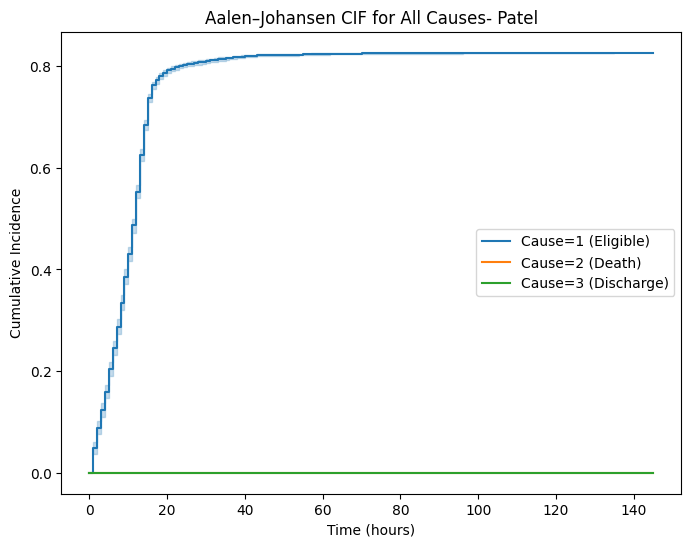

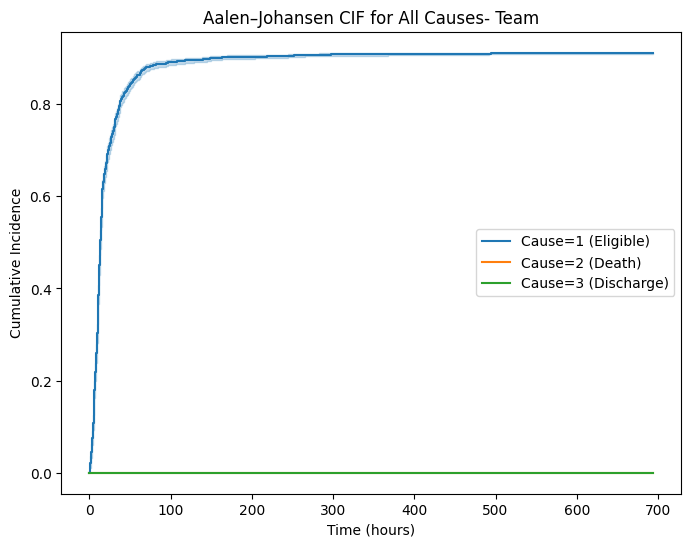

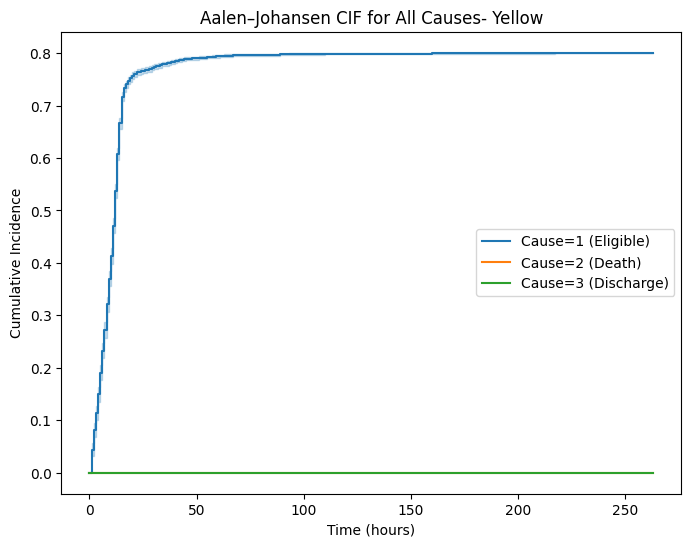

In [18]:
# The Aalen-Johansen estimator cannot handle tied event times.
# If a warning states - data is randomly jittered. It means that t_event is randomly changed by a very small number 0.00000001
main_competing_risk_analysis(df_patel_competing, "Patel")
main_competing_risk_analysis(df_team_competing, "Team")
main_competing_risk_analysis(df_yellow_competing, "Yellow")

In [19]:
from lifelines import AalenJohansenFitter

#########################
# 1) A helper to fit Aalen–Johansen for cause=1
#########################
def fit_aalen_johansen_cif(
    df,
    duration_col='t_event',
    event_col='outcome',
    cause_of_interest=1,
    calculate_variance=True
):
    """
    Fits an Aalen–Johansen estimator to compute the cumulative incidence
    of a given cause (cause_of_interest) in a multi-state/competing-risks scenario.

    Parameters
    ----------
    df : pd.DataFrame
        Must have columns [duration_col, event_col] with event_col in {1,2,3}.
        (No 0 => no censoring).
    duration_col : str
        Name of the column with time to event (e.g., 't_event').
    event_col : str
        Name of the column with the integer-coded event type.
    cause_of_interest : int
        Which cause you want the CIF for (1,2,3).
    calculate_variance : bool
        Whether to compute variance/confidence intervals (slows it down if large).

    Returns
    -------
    ajf : AalenJohansenFitter
        A lifelines AalenJohansenFitter object containing the fitted CIF.
        - ajf.cumulative_density_ => DataFrame with index 'timeline' & column(s) like 'CIF_1'
        - ajf.plot(...) => quick plotting method
    """

    # Drop any rows missing time or event
    df = df.dropna(subset=[duration_col, event_col]).copy()

    # Ensure event_col is int
    df[event_col] = df[event_col].astype(int)

    # Create the fitter
    ajf = AalenJohansenFitter(calculate_variance=calculate_variance)
    ajf.fit(
        durations=df[duration_col],
        event_observed=df[event_col],
        event_of_interest=cause_of_interest
    )
    return ajf


#########################
# 2) A function to extract CIF data & median from a fitted AalenJohansenFitter
#########################
def extract_cif_and_median(ajf):
    """
    Given a fitted AalenJohansenFitter, extract:
      - A DataFrame with columns [time, cif, lower_ci, upper_ci] (if variance was computed)
      - The approximate median time (time at which CIF crosses 0.5), or np.inf if never crosses

    Returns
    -------
    cif_df : pd.DataFrame
        Columns: time, cif, lower_ci, upper_ci
    median_time : float or np.inf
        The time at which CIF ~ 0.5
    """

    # The lifelines object stores the CIF in .cumulative_density_
    # The index is typically named 'timeline', and the main column is 'CIF_1'.
    df_cif = ajf.cumulative_density_.copy()  # a DataFrame indexed by timeline

    # Move the 'timeline' index to a 'time' column
    df_cif['time'] = df_cif.index
    df_cif.reset_index(drop=True, inplace=True)

    # Rename "CIF_1" -> "cif"
    if 'CIF_1' not in df_cif.columns:
        raise KeyError("Expected column 'CIF_1' in cumulative_density_, but not found. Check column names.")
    df_cif.rename(columns={'CIF_1': 'cif'}, inplace=True)

    # If user turned on variance, we may see columns like 'CIF_1_lower_0.95', 'CIF_1_upper_0.95'
    possible_lower = [col for col in df_cif.columns if '_lower_' in col]
    possible_upper = [col for col in df_cif.columns if '_upper_' in col]

    if possible_lower and possible_upper:
        df_cif.rename(columns={
            possible_lower[0]: 'lower_ci',
            possible_upper[0]: 'upper_ci'
        }, inplace=True)
    else:
        # No variance columns found => fill with NaN
        df_cif['lower_ci'] = np.nan
        df_cif['upper_ci'] = np.nan

    # Approximate median time => time at which CIF >= 0.5
    cif_vals = df_cif['cif'].values
    time_vals= df_cif['time'].values

    crossing_idx = np.where(cif_vals >= 0.5)[0]
    if len(crossing_idx) == 0:
        median_time = np.inf
    else:
        median_time = time_vals[crossing_idx[0]]

    return df_cif[['time','cif','lower_ci','upper_ci']], median_time


#########################
# 3) The main function
#########################
def main_competing_risk_analysis(
    df_patel_competing,
    df_team_competing,
    df_yellow_competing
):
    """
    1) Fit cause=1 (eligibility) Aalen–Johansen for each of the three data sets
    2) Plot them all on one figure
    3) Print & store the median times
    4) Save the CIF data (including variance if available) to CSV
       so you can share it w/o patient-level data
    """

    # 3a) Fit each with variance
    ajf_patel  = fit_aalen_johansen_cif(df_patel_competing, cause_of_interest=1, calculate_variance=True)
    ajf_team   = fit_aalen_johansen_cif(df_team_competing, cause_of_interest=1, calculate_variance=True)
    ajf_yellow = fit_aalen_johansen_cif(df_yellow_competing, cause_of_interest=1, calculate_variance=True)

    # 3b) Extract CIF data & median
    patel_cif_df,  patel_median  = extract_cif_and_median(ajf_patel)
    team_cif_df,   team_median   = extract_cif_and_median(ajf_team)
    yellow_cif_df, yellow_median = extract_cif_and_median(ajf_yellow)

    # 3c) Print median times
    print("=== Median Times to First Eligibility (Aalen–Johansen, cause=1) ===")
    print(f"Patel:  {patel_median} hours")
    print(f"TEAM:   {team_median} hours")
    print(f"Yellow: {yellow_median} hours")

    # 3d) Plot them all on one figure
    plt.figure(figsize=(8,6))
    plt.step(patel_cif_df['time'], patel_cif_df['cif'],  where='post', label="Patel")
    plt.step(team_cif_df['time'],  team_cif_df['cif'],   where='post', label="TEAM")
    plt.step(yellow_cif_df['time'],yellow_cif_df['cif'],where='post', label="Yellow")

    plt.title("CIF for Time to Eligibility (Cause=1) - Aalen–Johansen")
    plt.xlabel("Time (hours)")
    plt.ylabel("Cumulative Incidence")
    plt.legend()
    plt.show()

    # 3e) Optionally, save the combined CIF data to CSV
    patel_cif_df['Criteria']  = 'Patel'
    team_cif_df['Criteria']   = 'TEAM'
    yellow_cif_df['Criteria'] = 'Yellow'
    combined_cif_df = pd.concat([patel_cif_df, team_cif_df, yellow_cif_df], ignore_index=True)

    combined_cif_df.to_csv("../output/final/aalen_johansen_cif_eligibility.csv", index=False)
    print("\nSaved combined CIF data (with variance if available) to CSV.\n")


=== Median Times to First Eligibility (Aalen–Johansen, cause=1) ===
Patel:  12.0 hours
TEAM:   13.0 hours
Yellow: 12.0 hours


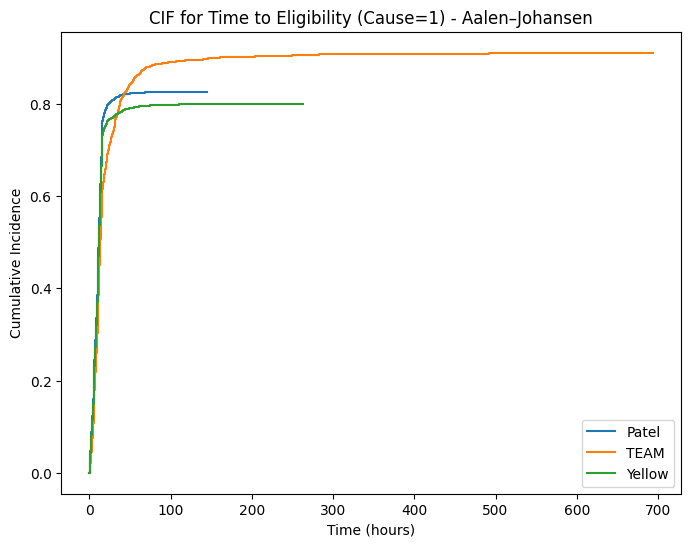


Saved combined CIF data (with variance if available) to CSV.



In [20]:
main_competing_risk_analysis(df_patel_competing, df_team_competing, df_yellow_competing)

In [21]:
ajf_patel  = fit_aalen_johansen_cif(df_patel_competing, cause_of_interest=1)
ajf_team   = fit_aalen_johansen_cif(df_team_competing, cause_of_interest=1)
ajf_yellow = fit_aalen_johansen_cif(df_yellow_competing, cause_of_interest=1)

In [22]:
ajf_patel

<lifelines.AalenJohansenFitter>

## Final figures and tables

1. Figure 1: Percentage of encounter satisfying Patel, TEAM, and any yellow or GREEN criteria
2. Figure 2: Percentage of business hours each encounter was eligible for different criteria
3. Figure 3: Percentage of business hours not eligible for each criteria broken down by subcomponent failure


### Eligibility by encounter

In [ ]:
def count_encounters_meeting_criteria(df):
    total_encounters = df['hospitalization_id'].nunique()  # Calculate total unique encounters
    # For each encounter, check if they ever met the criteria and sum up
    criteria_counts = df.groupby('hospitalization_id').agg(
        patel_met=('patel_flag', lambda x: x.max()),
        team_met=('team_flag', lambda x: x.max()),
        any_yellow_or_green_no_red_met=('any_yellow_or_green_no_red', lambda x: x.max()),
        all_green_no_red=('all_green_no_red', lambda x: x.max()),
        all_green=('all_green', lambda x: x.max()),
    ).sum().reset_index()

    criteria_counts.columns = ['Criteria', 'Number of Encounters']
    criteria_counts['Percentage'] = (criteria_counts['Number of Encounters'] / total_encounters) * 100
    criteria_counts['Total Encounters'] = total_encounters  # Save total_encounters in a column
    
    return criteria_counts

# Generate the criteria comparison table

criteria_comparison_table = count_encounters_meeting_criteria(business_hours_df)
criteria_comparison_table['site_name'] = pyCLIF.helper["site_name"]
pd.DataFrame(criteria_comparison_table).to_csv(f'../output/final/eligibility_by_hosp_{pyCLIF.helper["site_name"]}_{datetime.now().date()}.csv',index=False)
criteria_comparison_table

In [ ]:
# Rename the criteria for clarity
criteria_comparison_table['Criteria'] = criteria_comparison_table['Criteria'].replace({
    'patel_met': 'Patel',
    'team_met': 'TEAM',
    'any_yellow_or_green_no_red_met': 'Yellow'
})

# Define custom colors
custom_colors = ['#983232', '#003f5c', '#fdfd96']  # Maroon, Dark Blue, Pastel Yellow

# Plot the bar chart
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Criteria', y='Percentage', data=criteria_comparison_table, palette=custom_colors)

# Rotate the x-axis labels
# plt.xticks(rotation=90)

# Add percentages on top of the bars
for index, row in criteria_comparison_table.iterrows():
    barplot.text(index, row['Percentage'] + 0.5, f"{row['Percentage']:.1f}%", 
                 color='black', ha="center")

# Add labels and title
plt.xlabel('Criteria')
plt.ylabel('Percentage of Encounters')
# plt.title('Percentage of Encounters Meeting Each Criterion')

# Save the graph
plt.savefig(f'../output/final/graphs/eligibility_by_hosp_{pyCLIF.helper["site_name"]}_{datetime.now().date()}.png')

plt.show()

### Eligibility by business hour

In [ ]:
# Function to compute the percentage of business hours
def compute_percentage_hours_by_criteria(df, criteria_columns):
    """
    Compute the percentage of business hours each encounter was eligible for different criteria.
    """
    # Calculate the total number of business hours per encounter
    total_business_hours = df.groupby('hospitalization_id')['time_biz'].max()
    # Filter out encounters with zero business hours to avoid division by zero
    total_business_hours = total_business_hours[total_business_hours > 0]
    # Sum the number of hours each criterion is met for each encounter
    hours_criteria = df.groupby('hospitalization_id').agg({criterion: 'sum' for criterion in criteria_columns})
    # Retain only the encounters with non-zero business hours
    hours_criteria = hours_criteria.loc[total_business_hours.index]
    # Calculate the percentage of business hours met for each criterion
    percentage_hours_by_criteria = hours_criteria.divide(total_business_hours, axis=0) * 100
    # Calculate the mean percentage of hours met for each criterion across all encounters
    avg_percentage_by_criteria = percentage_hours_by_criteria.mean().reset_index()
    avg_percentage_by_criteria.columns = ['Criteria', 'Average Percentage of Hours Met']
    return avg_percentage_by_criteria

# Define the mapping for the criteria
criteria_columns = ['patel_flag', 'team_flag', 'any_yellow_or_green_no_red']
criteria_mapping = {
    'patel_flag': 'Patel',
    'team_flag': 'TEAM',
    'any_yellow_or_green_no_red': 'Yellow'
}

# Calculate the percentage of business hours met for each criterion
avg_percentage_by_criteria = compute_percentage_hours_by_criteria(business_hours_df, criteria_columns)

# Replace the criteria names according to the mapping
avg_percentage_by_criteria['Criteria'] = avg_percentage_by_criteria['Criteria'].replace(criteria_mapping)
avg_percentage_by_criteria['site_name'] = pyCLIF.helper["site_name"]
pd.DataFrame(avg_percentage_by_criteria).to_csv(f'../output/final/eligibility_by_hour_{pyCLIF.helper["site_name"]}_{datetime.now().date()}.csv',index=False)
avg_percentage_by_criteria


In [ ]:
# Create the bar plot
plt.figure(figsize=(10, 6))

# Custom colors for each criterion: Patel (Maroon), TEAM (Dark Blue), Yellow (Pastel Yellow)
custom_colors = ['#983232', '#003366', '#fdfd96']

ax = sns.barplot(x='Criteria', y='Average Percentage of Hours Met', data=avg_percentage_by_criteria, palette=custom_colors)

# Add the percentage as labels on top of the bars
for i, row in avg_percentage_by_criteria.iterrows():
    ax.text(i, row['Average Percentage of Hours Met'] + 0.5, f'{row["Average Percentage of Hours Met"]:.2f}%', 
            ha='center', color='black', fontsize=12)

# Customize the plot
plt.title('Percentage of Business Hours Each Encounter Was Eligible for Different Criteria')
plt.xlabel('Criteria')
plt.ylabel('Average Percentage of Business Hours (%)')

# Show the plot
plt.tight_layout()
plt.savefig(f'../output/final/graphs/eligibility_by_hour_{pyCLIF.helper["site_name"]}_{datetime.now().date()}.png')
plt.show()

### Failure by subcomponents

In [ ]:
# Define your criteria and corresponding subcomponent flags
criteria_info = {
    'patel_flag': {'resp_flag': 'patel_resp_flag', 'cardio_flag': 'patel_cardio_flag'},
    'team_flag': {'resp_flag': 'team_resp_flag', 'cardio_flag': 'team_cardio_flag'},
    'any_yellow_or_green_no_red': {'resp_flag': 'yellow_resp_flag', 'cardio_flag': 'yellow_cardio_flag'}
}

# Initialize an empty list to store results
results = []

# Loop over each criterion
for criterion, flags in criteria_info.items():
    resp_flag = flags['resp_flag']
    cardio_flag = flags['cardio_flag']
    
    # Calculate total hours per hospitalization_id
    total_hours = final_df.groupby('hospitalization_id').size().rename('total_hours')
    
    # Create failure indicators
    df_failure = final_df.copy()
    df_failure['resp_only_failure'] = ((df_failure[resp_flag] == 0) & (df_failure[cardio_flag] == 1)).astype(int)
    df_failure['cardio_only_failure'] = ((df_failure[resp_flag] == 1) & (df_failure[cardio_flag] == 0)).astype(int)
    df_failure['both_failures'] = ((df_failure[resp_flag] == 0) & (df_failure[cardio_flag] == 0)).astype(int)
    
    # Aggregate the counts per hospitalization_id
    failure_counts = df_failure.groupby('hospitalization_id')[['resp_only_failure', 'cardio_only_failure', 'both_failures']].sum()
    
    # Merge with total hours
    failure_counts = failure_counts.merge(total_hours, left_index=True, right_index=True)
    
    # Calculate percentages
    failure_counts['resp_only_failure_perc'] = (failure_counts['resp_only_failure'] * 100 / failure_counts['total_hours']).round(3)
    failure_counts['cardio_only_failure_perc'] = (failure_counts['cardio_only_failure'] * 100 / failure_counts['total_hours']).round(3)
    failure_counts['both_failures_perc'] = (failure_counts['both_failures'] * 100 / failure_counts['total_hours']).round(3)
    
    # Calculate total failure percentage
    failure_counts['total_failure_perc'] = (
        failure_counts['resp_only_failure'] + failure_counts['cardio_only_failure'] + failure_counts['both_failures']
    ) * 100 / failure_counts['total_hours']
    
    # Calculate criterion met percentage
    criterion_met = final_df.groupby('hospitalization_id')[criterion].sum().rename('criterion_met_hours')
    failure_counts = failure_counts.merge(criterion_met, left_index=True, right_index=True)
    failure_counts['criterion_met_perc'] = (failure_counts['criterion_met_hours'] * 100 / failure_counts['total_hours']).round(3)
    
    # Add criterion name to the DataFrame
    failure_counts['Criteria'] = criterion
    
    # Append to results
    results.append(failure_counts.reset_index())

# Concatenate results for all criteria
all_failure_counts = pd.concat(results, ignore_index=True)

# Now, calculate the average percentages across all hospitalizations for each criterion
avg_failure_percentages = all_failure_counts.groupby('Criteria').agg({
    'resp_only_failure_perc': 'mean',
    'cardio_only_failure_perc': 'mean',
    'both_failures_perc': 'mean',
    'total_failure_perc': 'mean',
    'criterion_met_perc': 'mean'
}).reset_index()

# Rename columns for clarity
avg_failure_percentages = avg_failure_percentages.rename(columns={
    'resp_only_failure_perc': 'Resp Failure Only',
    'cardio_only_failure_perc': 'Cardio Failure Only',
    'both_failures_perc': 'Both Failures',
    'total_failure_perc': 'Total Failure',
    'criterion_met_perc': 'Criterion Met'
})

# Display the average failure percentages
criteria_mapping = {
    'patel_flag': 'Patel',
    'team_flag': 'TEAM',
    'any_yellow_or_green_no_red': 'Yellow'
}

avg_failure_percentages['Criteria'] = avg_failure_percentages['Criteria'].replace(criteria_mapping)
avg_failure_percentages['site_name'] = pyCLIF.helper["site_name"]
pd.DataFrame(avg_failure_percentages).to_csv(f'../output/final/avg_failure_percentages_{pyCLIF.helper["site_name"]}_{datetime.now().date()}.csv',index=False)
avg_failure_percentages

In [ ]:
fig = go.Figure()

# Add bars for each criterion
fig.add_trace(go.Bar(
    x=avg_failure_percentages['Criteria'],
    y=avg_failure_percentages['Criterion Met'],
    marker=dict(color=avg_failure_percentages['Criteria'].map({
        'Yellow': '#fdfd96',
        'Patel': '#983232',
        'TEAM': '#003366'
    })),  # Custom colors
    text=avg_failure_percentages['Criterion Met'].round(2),
    textposition='auto'
))

# Customize the layout
fig.update_layout(
    # title='Average Percentage of Business Hours Each Criterion Is Met',
    xaxis_title='Criteria',
    yaxis_title='Average Percentage of Business Hours Met (%)',
    yaxis=dict(range=[0, 100]),  # Ensure y-axis range is 0-100%
    template='plotly_white'
)

# Save the plot
fig.write_image(f'../output/final/graphs/avg_failure_percentages_{pyCLIF.helper["site_name"]}_{datetime.now().date()}.png')
# fig.savefig(f'../output/final/graphs/avg_failure_percentages_{pyCLIF.helper["site_name"]}.png')

# Show the plot
fig.show()

In [ ]:
# Create a stacked bar plot using Plotly
fig = go.Figure()

# Add bars for Cardio Failure Only
fig.add_trace(go.Bar(
    x=avg_failure_percentages['Criteria'],
    y=avg_failure_percentages['Cardio Failure Only'],
    name='Cardio Failure Only',
    marker_color='#003366'  # Dark Blue
))

# Add bars for Resp Failure Only
fig.add_trace(go.Bar(
    x=avg_failure_percentages['Criteria'],
    y=avg_failure_percentages['Resp Failure Only'],
    name='Resp Failure Only',
    marker_color='#983232'  # Maroon
))

# Add bars for Both Failures
fig.add_trace(go.Bar(
    x=avg_failure_percentages['Criteria'],
    y=avg_failure_percentages['Both Failures'],
    name='Both Failures',
    marker_color='#fdfd96'  # Pastel Yellow
))

# Customize the layout
fig.update_layout(
    barmode='stack',
    xaxis_title='Criteria',
    yaxis_title='Average Percentage of Business Hours Not Met (%)',
    yaxis=dict(range=[0, 100]),
    template='plotly_white',
    legend_title='Failure Type'
)
# Save the plot
fig.write_image(f'../output/final/graphs/avg_failure_components_{pyCLIF.helper["site_name"]}_{datetime.now().date()}.png')
# Show the plot
fig.show()


### Time to eligibility from intubation

This analysis includes a 4 hour "cool off" period


In [23]:
# Filter the DataFrame for rows where the Patel criteria are met
patel_eligible_df = business_hours_df[business_hours_df['patel_flag'] == 1]

# Find the first time each patient meets the Patel criteria
first_eligibility_times_patel = patel_eligible_df.groupby('hospitalization_id')['time_from_vent'].min().reset_index()

# Create the survival analysis dataset
survival_analysis_df_patel = business_hours_df[['hospitalization_id']].drop_duplicates().copy()

# Merge with the first eligibility times
survival_analysis_df_patel = pd.merge(survival_analysis_df_patel, first_eligibility_times_patel, on='hospitalization_id', how='left')

# Fill NaN values with 27 for patients who were never eligible
survival_analysis_df_patel['time_from_vent'] = survival_analysis_df_patel['time_from_vent'].fillna(27)

# Create the 'eligible' column
survival_analysis_df_patel['eligible'] = (survival_analysis_df_patel['time_from_vent'] != 27).astype(int)

# Rename columns
survival_analysis_df_patel.rename(columns={'time_from_vent': 'time_to_first_eligibility'}, inplace=True)

# Add +1 to time_to_first_eligibility
survival_analysis_df_patel['time_to_first_eligibility'] = survival_analysis_df_patel['time_to_first_eligibility'] + 1

# Display the final dataset
print(survival_analysis_df_patel.head())

# Repeat the process for TEAM criteria
team_eligible_df = business_hours_df[business_hours_df['team_flag'] == 1]
first_eligibility_times_team = team_eligible_df.groupby('hospitalization_id')['time_from_vent'].min().reset_index()
survival_analysis_df_team = business_hours_df[['hospitalization_id']].drop_duplicates().copy()
survival_analysis_df_team = pd.merge(survival_analysis_df_team, first_eligibility_times_team, on='hospitalization_id', how='left')
survival_analysis_df_team['time_from_vent'] = survival_analysis_df_team['time_from_vent'].fillna(27)
survival_analysis_df_team['eligible'] = (survival_analysis_df_team['time_from_vent'] != 27).astype(int)
survival_analysis_df_team.rename(columns={'time_from_vent': 'time_to_first_eligibility'}, inplace=True)
survival_analysis_df_team['time_to_first_eligibility'] = survival_analysis_df_team['time_to_first_eligibility'] + 1

# Repeat the process for Yellow criteria
yellow_eligible_df = business_hours_df[business_hours_df['any_yellow_or_green_no_red'] == 1]
first_eligibility_times_yellow = yellow_eligible_df.groupby('hospitalization_id')['time_from_vent'].min().reset_index()
survival_analysis_df_yellow = business_hours_df[['hospitalization_id']].drop_duplicates().copy()
survival_analysis_df_yellow = pd.merge(survival_analysis_df_yellow, first_eligibility_times_yellow, on='hospitalization_id', how='left')
survival_analysis_df_yellow['time_from_vent'] = survival_analysis_df_yellow['time_from_vent'].fillna(27)
survival_analysis_df_yellow['eligible'] = (survival_analysis_df_yellow['time_from_vent'] != 27).astype(int)
survival_analysis_df_yellow.rename(columns={'time_from_vent': 'time_to_first_eligibility'}, inplace=True)
survival_analysis_df_yellow['time_to_first_eligibility'] = survival_analysis_df_yellow['time_to_first_eligibility'] + 1

# Display the final datasets
print(survival_analysis_df_team.head())
print(survival_analysis_df_yellow.head())

  hospitalization_id  time_to_first_eligibility  eligible
0           24520276                       18.0         1
1           20808677                       18.0         1
2            3429646                       23.0         1
3           16989571                       17.0         1
4            5507881                       14.0         1
  hospitalization_id  time_to_first_eligibility  eligible
0           24520276                       17.0         1
1           20808677                       16.0         1
2            3429646                       28.0         0
3           16989571                       28.0         0
4            5507881                       28.0         0
  hospitalization_id  time_to_first_eligibility  eligible
0           24520276                       18.0         1
1           20808677                       18.0         1
2            3429646                       25.0         1
3           16989571                       17.0         1
4            5

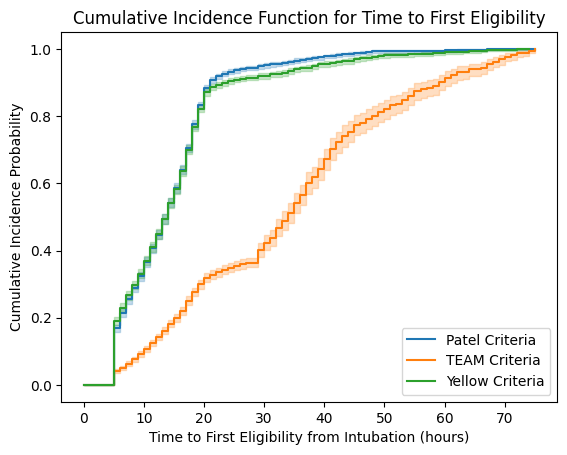

Median time to first eligibility (Patel): 14.0 hours
Median time to first eligibility (TEAM): 34.0 hours
Median time to first eligibility (Yellow): 14.0 hours
Cumulative Incidence Function value at time = 1 (Patel): 0%
Cumulative Incidence Function value at time = 1 (TEAM): 0%
Cumulative Incidence Function value at time = 1 (Yellow): 0%


In [24]:
# Initialize the KaplanMeierFitter for Patel, TEAM and Yellow criteria
kmf_patel = KaplanMeierFitter()
kmf_team = KaplanMeierFitter()
kmf_yellow = KaplanMeierFitter()

# fit the data for Patel criteria
kmf_patel.fit(durations=survival_analysis_df_patel['time_to_first_eligibility'], event_observed=survival_analysis_df_patel['eligible'], label='Patel Criteria')

# Fit the data for TEAM criteria
kmf_team.fit(durations=survival_analysis_df_team['time_to_first_eligibility'], event_observed=survival_analysis_df_team['eligible'], label='TEAM Criteria')

# Fit the data for Yellow criteria
kmf_yellow.fit(durations=survival_analysis_df_yellow['time_to_first_eligibility'], event_observed=survival_analysis_df_yellow['eligible'], label='Yellow Criteria')

# Plot the cumulative incidence function for all criteria
ax = kmf_patel.plot_cumulative_density()
kmf_team.plot_cumulative_density(ax=ax)
kmf_yellow.plot_cumulative_density(ax=ax)

plt.title('Cumulative Incidence Function for Time to First Eligibility')
plt.xlabel('Time to First Eligibility from Intubation (hours)')
plt.ylabel('Cumulative Incidence Probability')
plt.legend()

# Save the plot
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
plt.savefig(f'../output/final/graphs/cif_{pyCLIF.helper["site_name"]}_{timestamp}.png')

plt.show()

# Estimate the median time to first eligibility for all criteria
median_time_to_first_eligibility_patel = kmf_patel.median_survival_time_
median_time_to_first_eligibility_team = kmf_team.median_survival_time_
median_time_to_first_eligibility_yellow = kmf_yellow.median_survival_time_

print(f"Median time to first eligibility (Patel): {median_time_to_first_eligibility_patel} hours")
print(f"Median time to first eligibility (TEAM): {median_time_to_first_eligibility_team} hours")
print(f"Median time to first eligibility (Yellow): {median_time_to_first_eligibility_yellow} hours")

# Calculate the cumulative incidence function value at time = 1 for all criteria
cif_value_at_1_patel = 1 - kmf_patel.predict(1)
cif_value_at_1_team = 1 - kmf_team.predict(1)
cif_value_at_1_yellow = 1 - kmf_yellow.predict(1)

print(f"Cumulative Incidence Function value at time = 1 (Patel): {cif_value_at_1_patel:.0%}")
print(f"Cumulative Incidence Function value at time = 1 (TEAM): {cif_value_at_1_team:.0%}")
print(f"Cumulative Incidence Function value at time = 1 (Yellow): {cif_value_at_1_yellow:.0%}")


# Save the cumulative incidence function data to CSV files
cif_patel = kmf_patel.cumulative_density_.reset_index()
cif_team = kmf_team.cumulative_density_.reset_index()
cif_yellow = kmf_yellow.cumulative_density_.reset_index()

# Add a column to identify the criteria
cif_patel['Criteria'] = 'Patel'
cif_team['Criteria'] = 'TEAM'
cif_yellow['Criteria'] = 'Yellow'

# Get the site name from pyCLIF helper
site_name = pyCLIF.helper["site_name"]

cif_patel['Site'] = site_name
cif_team['Site'] = site_name
cif_yellow['Site'] = site_name

# Save to CSV files with site name in the file names
timestamp = datetime.now().date()
cif_patel.to_csv(f'../output/final/cif_patel_{pyCLIF.helper["site_name"]}_{timestamp}.csv', index=False)
cif_team.to_csv(f'../output/final/cif_team_{pyCLIF.helper["site_name"]}_{timestamp}.csv', index=False)
cif_yellow.to_csv(f'../output/final/cif_yellow_{pyCLIF.helper["site_name"]}_{timestamp}.csv', index=False)

# Calculate 95% CI for each criteria
ci_patel_ci = kmf_patel.confidence_interval_cumulative_density_.reset_index()
ci_team_ci = kmf_team.confidence_interval_cumulative_density_.reset_index()
ci_yellow_ci = kmf_yellow.confidence_interval_cumulative_density_.reset_index()

# Add a column to identify the criteria
ci_patel_ci['Criteria'] = 'Patel'
ci_team_ci['Criteria'] = 'TEAM'
ci_yellow_ci['Criteria'] = 'Yellow'
ci_patel_ci['Site'] = site_name
ci_team_ci['Site'] = site_name
ci_yellow_ci['Site'] = site_name
# Save to CSV files with site name in the file names
timestamp = datetime.now().date()
ci_patel_ci.to_csv(f'../output/final/cif_patel_ci_{pyCLIF.helper["site_name"]}_{timestamp}.csv', index=False)
ci_team_ci.to_csv(f'../output/final/cif_team_ci_{pyCLIF.helper["site_name"]}_{timestamp}.csv', index=False)
ci_yellow_ci.to_csv(f'../output/final/cif_yellow_ci_{pyCLIF.helper["site_name"]}_{timestamp}.csv', index=False)

In [25]:
# Filter the DataFrame for rows where the Patel criteria are met
patel_eligible_df = business_hours_df[business_hours_df['patel_flag'] == 1]

# Find the first time each patient meets the Patel criteria
first_eligibility_times_patel = patel_eligible_df.groupby('hospitalization_id')['time_biz'].min().reset_index()

# Create the survival analysis dataset
survival_analysis_df_patel = business_hours_df[['hospitalization_id']].drop_duplicates().copy()

# Merge with the first eligibility times
survival_analysis_df_patel = pd.merge(survival_analysis_df_patel, first_eligibility_times_patel, on='hospitalization_id', how='left')

# Fill NaN values with 27 for patients who were never eligible
survival_analysis_df_patel['time_biz'] = survival_analysis_df_patel['time_biz'].fillna(27)

# Create the 'eligible' column
survival_analysis_df_patel['eligible'] = (survival_analysis_df_patel['time_biz'] != 27).astype(int)

# Rename columns
survival_analysis_df_patel.rename(columns={'time_biz': 'time_to_first_eligibility'}, inplace=True)

# Add +1 to time_to_first_eligibility
survival_analysis_df_patel['time_to_first_eligibility'] = survival_analysis_df_patel['time_to_first_eligibility'] + 1

# Display the final dataset
print(survival_analysis_df_patel.head())

# Repeat the process for TEAM criteria
team_eligible_df = business_hours_df[business_hours_df['team_flag'] == 1]
first_eligibility_times_team = team_eligible_df.groupby('hospitalization_id')['time_biz'].min().reset_index()
survival_analysis_df_team = business_hours_df[['hospitalization_id']].drop_duplicates().copy()
survival_analysis_df_team = pd.merge(survival_analysis_df_team, first_eligibility_times_team, on='hospitalization_id', how='left')
survival_analysis_df_team['time_biz'] = survival_analysis_df_team['time_biz'].fillna(27)
survival_analysis_df_team['eligible'] = (survival_analysis_df_team['time_biz'] != 27).astype(int)
survival_analysis_df_team.rename(columns={'time_biz': 'time_to_first_eligibility'}, inplace=True)
survival_analysis_df_team['time_to_first_eligibility'] = survival_analysis_df_team['time_to_first_eligibility'] + 1

# Repeat the process for Yellow criteria
yellow_eligible_df = business_hours_df[business_hours_df['any_yellow_or_green_no_red'] == 1]
first_eligibility_times_yellow = yellow_eligible_df.groupby('hospitalization_id')['time_biz'].min().reset_index()
survival_analysis_df_yellow = business_hours_df[['hospitalization_id']].drop_duplicates().copy()
survival_analysis_df_yellow = pd.merge(survival_analysis_df_yellow, first_eligibility_times_yellow, on='hospitalization_id', how='left')
survival_analysis_df_yellow['time_biz'] = survival_analysis_df_yellow['time_biz'].fillna(27)
survival_analysis_df_yellow['eligible'] = (survival_analysis_df_yellow['time_biz'] != 27).astype(int)
survival_analysis_df_yellow.rename(columns={'time_biz': 'time_to_first_eligibility'}, inplace=True)
survival_analysis_df_yellow['time_to_first_eligibility'] = survival_analysis_df_yellow['time_to_first_eligibility'] + 1

# Display the final datasets
print(survival_analysis_df_team.head())
print(survival_analysis_df_yellow.head())

  hospitalization_id  time_to_first_eligibility  eligible
0           24520276                        2.0         1
1           20808677                        3.0         1
2            3429646                        4.0         1
3           16989571                        1.0         1
4            5507881                        2.0         1
  hospitalization_id  time_to_first_eligibility  eligible
0           24520276                        1.0         1
1           20808677                        1.0         1
2            3429646                       28.0         0
3           16989571                       28.0         0
4            5507881                       28.0         0
  hospitalization_id  time_to_first_eligibility  eligible
0           24520276                        2.0         1
1           20808677                        3.0         1
2            3429646                        6.0         1
3           16989571                        1.0         1
4            5

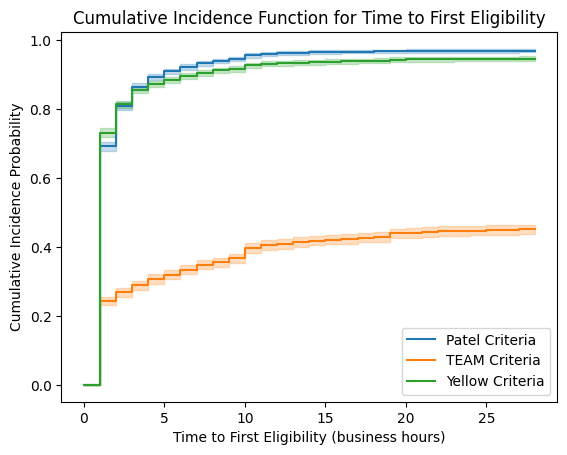

Median time to first eligibility (Patel): 1.0 hours
Median time to first eligibility (TEAM): inf hours
Median time to first eligibility (Yellow): 1.0 hours
Cumulative Incidence Function value at time = 1 (Patel): 69%
Cumulative Incidence Function value at time = 1 (TEAM): 24%
Cumulative Incidence Function value at time = 1 (Yellow): 73%


In [26]:
# Initialize the KaplanMeierFitter for Patel, TEAM and Yellow criteria
kmf_patel = KaplanMeierFitter()
kmf_team = KaplanMeierFitter()
kmf_yellow = KaplanMeierFitter()

# fit the data for Patel criteria
kmf_patel.fit(durations=survival_analysis_df_patel['time_to_first_eligibility'], event_observed=survival_analysis_df_patel['eligible'], label='Patel Criteria')

# Fit the data for TEAM criteria
kmf_team.fit(durations=survival_analysis_df_team['time_to_first_eligibility'], event_observed=survival_analysis_df_team['eligible'], label='TEAM Criteria')

# Fit the data for Yellow criteria
kmf_yellow.fit(durations=survival_analysis_df_yellow['time_to_first_eligibility'], event_observed=survival_analysis_df_yellow['eligible'], label='Yellow Criteria')

# Plot the cumulative incidence function for all criteria
ax = kmf_patel.plot_cumulative_density()
kmf_team.plot_cumulative_density(ax=ax)
kmf_yellow.plot_cumulative_density(ax=ax)

plt.title('Cumulative Incidence Function for Time to First Eligibility')
plt.xlabel('Time to First Eligibility (business hours)')
plt.ylabel('Cumulative Incidence Probability')
# Save the plot
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
plt.savefig(f'../output/final/graphs/cif_b_hours_{pyCLIF.helper["site_name"]}_{timestamp}.png')
plt.legend()
plt.show()

# Estimate the median time to first eligibility for all criteria
median_time_to_first_eligibility_patel = kmf_patel.median_survival_time_
median_time_to_first_eligibility_team = kmf_team.median_survival_time_
median_time_to_first_eligibility_yellow = kmf_yellow.median_survival_time_

print(f"Median time to first eligibility (Patel): {median_time_to_first_eligibility_patel} hours")
print(f"Median time to first eligibility (TEAM): {median_time_to_first_eligibility_team} hours")
print(f"Median time to first eligibility (Yellow): {median_time_to_first_eligibility_yellow} hours")

# Calculate the cumulative incidence function value at time = 1 for all criteria
cif_value_at_1_patel = 1 - kmf_patel.predict(1)
cif_value_at_1_team = 1 - kmf_team.predict(1)
cif_value_at_1_yellow = 1 - kmf_yellow.predict(1)

print(f"Cumulative Incidence Function value at time = 1 (Patel): {cif_value_at_1_patel:.0%}")
print(f"Cumulative Incidence Function value at time = 1 (TEAM): {cif_value_at_1_team:.0%}")
print(f"Cumulative Incidence Function value at time = 1 (Yellow): {cif_value_at_1_yellow:.0%}")


# Save the cumulative incidence function data to CSV files
cif_patel = kmf_patel.cumulative_density_.reset_index()
cif_team = kmf_team.cumulative_density_.reset_index()
cif_yellow = kmf_yellow.cumulative_density_.reset_index()

# Add a column to identify the criteria
cif_patel['Criteria'] = 'Patel'
cif_team['Criteria'] = 'TEAM'
cif_yellow['Criteria'] = 'Yellow'


# Get the site name from pyCLIF helper
site_name = pyCLIF.helper["site_name"]

cif_patel['Site'] = site_name
cif_team['Site'] = site_name
cif_yellow['Site'] = site_name

# Save to CSV files with site name in the file names
timestamp = datetime.now().date()
cif_patel.to_csv(f'../output/final/cif_b_hours_patel_{pyCLIF.helper["site_name"]}_{timestamp}.csv', index=False)
cif_team.to_csv(f'../output/final/cif_b_hours_team_{pyCLIF.helper["site_name"]}_{timestamp}.csv', index=False)
cif_yellow.to_csv(f'../output/final/cif_b_hours_yellow_{pyCLIF.helper["site_name"]}_{timestamp}.csv', index=False)

# Calculate 95% CI for each criteria
ci_patel_ci = kmf_patel.confidence_interval_cumulative_density_.reset_index()
ci_team_ci = kmf_team.confidence_interval_cumulative_density_.reset_index()
ci_yellow_ci = kmf_yellow.confidence_interval_cumulative_density_.reset_index()

# Add a column to identify the criteria
ci_patel_ci['Criteria'] = 'Patel'
ci_team_ci['Criteria'] = 'TEAM'
ci_yellow_ci['Criteria'] = 'Yellow'
ci_patel_ci['Site'] = site_name
ci_team_ci['Site'] = site_name
ci_yellow_ci['Site'] = site_name
# Save to CSV files with site name in the file names
timestamp = datetime.now().date()
ci_patel_ci.to_csv(f'../output/final/cif_b_hours_patel_ci_{pyCLIF.helper["site_name"]}_{timestamp}.csv', index=False)
ci_team_ci.to_csv(f'../output/final/cif_b_hours_team_ci_{pyCLIF.helper["site_name"]}_{timestamp}.csv', index=False)
ci_yellow_ci.to_csv(f'../output/final/cif_b_hours_yellow_ci_{pyCLIF.helper["site_name"]}_{timestamp}.csv', index=False)

  hospitalization_id  time_to_first_eligibility  eligible
0           24520276                        2.0         1
1           20808677                        3.0         1
2            3429646                        4.0         1
3           16989571                        1.0         1
4            5507881                        2.0         1
  hospitalization_id  time_to_first_eligibility  eligible
0           24520276                        1.0         1
1           20808677                        1.0         1
2            3429646                       28.0         0
3           16989571                       28.0         0
4            5507881                       28.0         0
  hospitalization_id  time_to_first_eligibility  eligible
0           24520276                        2.0         1
1           20808677                        3.0         1
2            3429646                        6.0         1
3           16989571                        1.0         1
4            5

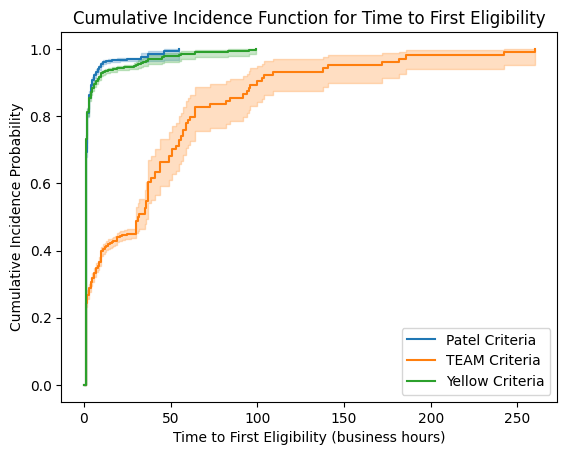

Median time to first eligibility (Patel): 1.0 hours
Median time to first eligibility (TEAM): 32.0 hours
Median time to first eligibility (Yellow): 1.0 hours
Cumulative Incidence Function value at time = 1 (Patel): 69%
Cumulative Incidence Function value at time = 1 (TEAM): 24%
Cumulative Incidence Function value at time = 1 (Yellow): 73%


In [27]:
#Note: `time_from_vent_adjusted` is -1 until hour 4, then it counts up from 0. This builds in the 4-hour cool off period.
business_hours_df = final_df[(final_df['time_from_vent_adjusted'] >= 0)]
#business_hours_df = final_df[(final_df['time_from_vent'] >= 0) & (final_df['time_from_vent'] < 72)]

# recorded_hour is the hour of the day (0-23), so business hours are 8 (8 AM) - 17 (5 PM).
business_hours_df = business_hours_df[(business_hours_df['recorded_hour'] >= 8) & (business_hours_df['recorded_hour'] < 17)].copy()
business_hours_df['time_biz'] = business_hours_df.groupby('hospitalization_id').cumcount()

# Filter the DataFrame for rows where the Patel criteria are met
patel_eligible_df = business_hours_df[business_hours_df['patel_flag'] == 1]

# Find the first time each patient meets the Patel criteria
first_eligibility_times_patel = patel_eligible_df.groupby('hospitalization_id')['time_biz'].min().reset_index()

# Create the survival analysis dataset
survival_analysis_df_patel = business_hours_df[['hospitalization_id']].drop_duplicates().copy()

# Merge with the first eligibility times
survival_analysis_df_patel = pd.merge(survival_analysis_df_patel, first_eligibility_times_patel, on='hospitalization_id', how='left')

# Fill NaN values with 27 for patients who were never eligible
survival_analysis_df_patel['time_biz'] = survival_analysis_df_patel['time_biz'].fillna(27)

# Create the 'eligible' column
survival_analysis_df_patel['eligible'] = (survival_analysis_df_patel['time_biz'] != 27).astype(int)

# Rename columns
survival_analysis_df_patel.rename(columns={'time_biz': 'time_to_first_eligibility'}, inplace=True)

# Add +1 to time_to_first_eligibility
survival_analysis_df_patel['time_to_first_eligibility'] = survival_analysis_df_patel['time_to_first_eligibility'] + 1

# Display the final dataset
print(survival_analysis_df_patel.head())

# Repeat the process for TEAM criteria
team_eligible_df = business_hours_df[business_hours_df['team_flag'] == 1]
first_eligibility_times_team = team_eligible_df.groupby('hospitalization_id')['time_biz'].min().reset_index()
survival_analysis_df_team = business_hours_df[['hospitalization_id']].drop_duplicates().copy()
survival_analysis_df_team = pd.merge(survival_analysis_df_team, first_eligibility_times_team, on='hospitalization_id', how='left')
survival_analysis_df_team['time_biz'] = survival_analysis_df_team['time_biz'].fillna(27)
survival_analysis_df_team['eligible'] = (survival_analysis_df_team['time_biz'] != 27).astype(int)
survival_analysis_df_team.rename(columns={'time_biz': 'time_to_first_eligibility'}, inplace=True)
survival_analysis_df_team['time_to_first_eligibility'] = survival_analysis_df_team['time_to_first_eligibility'] + 1

# Repeat the process for Yellow criteria
yellow_eligible_df = business_hours_df[business_hours_df['any_yellow_or_green_no_red'] == 1]
first_eligibility_times_yellow = yellow_eligible_df.groupby('hospitalization_id')['time_biz'].min().reset_index()
survival_analysis_df_yellow = business_hours_df[['hospitalization_id']].drop_duplicates().copy()
survival_analysis_df_yellow = pd.merge(survival_analysis_df_yellow, first_eligibility_times_yellow, on='hospitalization_id', how='left')
survival_analysis_df_yellow['time_biz'] = survival_analysis_df_yellow['time_biz'].fillna(27)
survival_analysis_df_yellow['eligible'] = (survival_analysis_df_yellow['time_biz'] != 27).astype(int)
survival_analysis_df_yellow.rename(columns={'time_biz': 'time_to_first_eligibility'}, inplace=True)
survival_analysis_df_yellow['time_to_first_eligibility'] = survival_analysis_df_yellow['time_to_first_eligibility'] + 1

# Display the final datasets
print(survival_analysis_df_team.head())
print(survival_analysis_df_yellow.head())

# Initialize the KaplanMeierFitter for Patel, TEAM and Yellow criteria
kmf_patel = KaplanMeierFitter()
kmf_team = KaplanMeierFitter()
kmf_yellow = KaplanMeierFitter()

# fit the data for Patel criteria
kmf_patel.fit(durations=survival_analysis_df_patel['time_to_first_eligibility'], event_observed=survival_analysis_df_patel['eligible'], label='Patel Criteria')

# Fit the data for TEAM criteria
kmf_team.fit(durations=survival_analysis_df_team['time_to_first_eligibility'], event_observed=survival_analysis_df_team['eligible'], label='TEAM Criteria')

# Fit the data for Yellow criteria
kmf_yellow.fit(durations=survival_analysis_df_yellow['time_to_first_eligibility'], event_observed=survival_analysis_df_yellow['eligible'], label='Yellow Criteria')

# Plot the cumulative incidence function for all criteria
ax = kmf_patel.plot_cumulative_density()
kmf_team.plot_cumulative_density(ax=ax)
kmf_yellow.plot_cumulative_density(ax=ax)

plt.title('Cumulative Incidence Function for Time to First Eligibility')
plt.xlabel('Time to First Eligibility (business hours)')
plt.ylabel('Cumulative Incidence Probability')
# Save the plot
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
plt.savefig(f'../output/final/graphs/cif_b_hours_{pyCLIF.helper["site_name"]}_{timestamp}.png')
plt.legend()
plt.show()

# Estimate the median time to first eligibility for all criteria
median_time_to_first_eligibility_patel = kmf_patel.median_survival_time_
median_time_to_first_eligibility_team = kmf_team.median_survival_time_
median_time_to_first_eligibility_yellow = kmf_yellow.median_survival_time_

print(f"Median time to first eligibility (Patel): {median_time_to_first_eligibility_patel} hours")
print(f"Median time to first eligibility (TEAM): {median_time_to_first_eligibility_team} hours")
print(f"Median time to first eligibility (Yellow): {median_time_to_first_eligibility_yellow} hours")

# Calculate the cumulative incidence function value at time = 1 for all criteria
cif_value_at_1_patel = 1 - kmf_patel.predict(1)
cif_value_at_1_team = 1 - kmf_team.predict(1)
cif_value_at_1_yellow = 1 - kmf_yellow.predict(1)

print(f"Cumulative Incidence Function value at time = 1 (Patel): {cif_value_at_1_patel:.0%}")
print(f"Cumulative Incidence Function value at time = 1 (TEAM): {cif_value_at_1_team:.0%}")
print(f"Cumulative Incidence Function value at time = 1 (Yellow): {cif_value_at_1_yellow:.0%}")


# Save the cumulative incidence function data to CSV files
cif_patel = kmf_patel.cumulative_density_.reset_index()
cif_team = kmf_team.cumulative_density_.reset_index()
cif_yellow = kmf_yellow.cumulative_density_.reset_index()

# Add a column to identify the criteria
cif_patel['Criteria'] = 'Patel'
cif_team['Criteria'] = 'TEAM'
cif_yellow['Criteria'] = 'Yellow'


# Get the site name from pyCLIF helper
site_name = pyCLIF.helper["site_name"]

cif_patel['Site'] = site_name
cif_team['Site'] = site_name
cif_yellow['Site'] = site_name

# Save to CSV files with site name in the file names
timestamp = datetime.now().date()
cif_patel.to_csv(f'../output/final/cif_b_hours_patel_{pyCLIF.helper["site_name"]}_{timestamp}.csv', index=False)
cif_team.to_csv(f'../output/final/cif_b_hours_team_{pyCLIF.helper["site_name"]}_{timestamp}.csv', index=False)
cif_yellow.to_csv(f'../output/final/cif_b_hours_yellow_{pyCLIF.helper["site_name"]}_{timestamp}.csv', index=False)

# Calculate 95% CI for each criteria
ci_patel_ci = kmf_patel.confidence_interval_cumulative_density_.reset_index()
ci_team_ci = kmf_team.confidence_interval_cumulative_density_.reset_index()
ci_yellow_ci = kmf_yellow.confidence_interval_cumulative_density_.reset_index()

# Add a column to identify the criteria
ci_patel_ci['Criteria'] = 'Patel'
ci_team_ci['Criteria'] = 'TEAM'
ci_yellow_ci['Criteria'] = 'Yellow'
ci_patel_ci['Site'] = site_name
ci_team_ci['Site'] = site_name
ci_yellow_ci['Site'] = site_name
# Save to CSV files with site name in the file names
timestamp = datetime.now().date()
ci_patel_ci.to_csv(f'../output/final/cif_b_hours_patel_ci_{pyCLIF.helper["site_name"]}_{timestamp}.csv', index=False)
ci_team_ci.to_csv(f'../output/final/cif_b_hours_team_ci_{pyCLIF.helper["site_name"]}_{timestamp}.csv', index=False)
ci_yellow_ci.to_csv(f'../output/final/cif_b_hours_yellow_ci_{pyCLIF.helper["site_name"]}_{timestamp}.csv', index=False)

### Aggregates for comparison across sites

In [34]:
# Total observed business hours
total_observed_hours = business_hours_df.shape[0]
# Total number of patients
total_patients = business_hours_df['hospitalization_id'].nunique()

In [ ]:
criteria_list = [
    ('patel_flag', 'Patel'),
    ('team_flag', 'TEAM'),
    ('any_yellow_or_green_no_red', 'Yellow')
]

aggregate_data = []

for flag_column, criterion_name in criteria_list:
    # Filter the DataFrame for rows where the criterion is met
    eligible_df = business_hours_df[business_hours_df[flag_column] == 1]

    # Total eligible hours for the criterion
    eligible_hours = eligible_df.shape[0]
    
    # Find the first time each patient meets the criterion
    first_eligibility_times = eligible_df.groupby('hospitalization_id')['time_biz'].min().reset_index()
    
    # Create the survival analysis dataset
    survival_analysis_df = business_hours_df[['hospitalization_id']].drop_duplicates().copy()
    
    # Merge with the first eligibility times
    survival_analysis_df = pd.merge(
        survival_analysis_df,
        first_eligibility_times,
        on='hospitalization_id',
        how='left'
    )
    # Fill NaN values with 27 for patients who were never eligible
    survival_analysis_df['time_biz'] = survival_analysis_df['time_biz'].fillna(27)
    # Create the 'eligible' column
    survival_analysis_df['eligible'] = (survival_analysis_df['time_biz'] != 27).astype(int)
    # Rename columns
    survival_analysis_df.rename(columns={'time_biz': 'time_to_first_eligibility'}, inplace=True)
    # Add +1 to time_to_first_eligibility
    survival_analysis_df['time_to_first_eligibility'] = survival_analysis_df_patel['time_to_first_eligibility'] + 1
    # Median time to first eligibility
    median_time = survival_analysis_df[survival_analysis_df['eligible'] == 1]['time_to_first_eligibility'].median()
    # Number of patients who became eligible
    eligible_patients = survival_analysis_df['eligible'].sum()
    # Confidence intervals for median time (optional)
    # Using bootstrapping for confidence intervals
    median_times = survival_analysis_df[survival_analysis_df['eligible'] == 1]['time_to_first_eligibility']
    ci_lower = median_times.quantile(0.25)
    ci_upper = median_times.quantile(0.75)
    
    # Append to aggregate data list
    aggregate_data.append({
        'Criteria': criterion_name,
        'Total Patients': total_patients,
        'Eligible Patients': eligible_patients,
        'Total Observed Hours': total_observed_hours,
        'Eligible Hours': eligible_hours,
        'Median Time': median_time,
        'CI Lower Median Time': ci_lower,
        'CI Upper Median Time': ci_upper
    })
    
    # Save the cumulative incidence function data if needed
    kmf = KaplanMeierFitter()
    kmf.fit(
        durations=survival_analysis_df['time_to_first_eligibility'],
        event_observed=survival_analysis_df['eligible'],
        label=f'{criterion_name} Criteria'
    )
    cif = kmf.cumulative_density_.reset_index()
    cif['Criteria'] = criterion_name
    
# Create a DataFrame for aggregate data
aggregate_df = pd.DataFrame(aggregate_data)

# Save the aggregate data to CSV
aggregate_df.to_csv(f'../output/final/aggregates_{pyCLIF.helper["site_name"]}_{timestamp}.csv', index=False)

# Print the aggregate data
print(aggregate_df)

### Average Hours Criteria Met on Days 1, 2, and 3

Determine how many hours the criteria are met on specific calendar days (Day 1, Day 2, Day 3 after intubation).

1. First, assign a calendar_day column that represents the calendar day relative to intubation.
2. Use the recorded_date and recorded hour to calculate the difference from the intubation time, and categorize rows into Day 1, Day 2, Day 3.
3. For each encounter, group the data by calendar_day and hospitalization_id and sum the hours that meet each criterion.
4. Compute the average number of hours for each criterion per day.


In [ ]:
business_hours_df

In [ ]:
vent_start_end

In [ ]:
# Merge business_hours_df with vent_start_end to get 'vent_start_time'
visualization_df = pd.merge(
    business_hours_df,
    vent_start_end[['encounter_block', 'block_vent_start_dttm']],
    on='encounter_block',
    how='left'
)

# Ensure 'vent_start_time' and 'recorded_date' are in datetime format
visualization_df['block_vent_start_dttm'] = pd.to_datetime(visualization_df['block_vent_start_dttm'])
visualization_df['recorded_date'] = pd.to_datetime(visualization_df['recorded_date'])

# Combine 'recorded_date' and 'recorded_hour' to create 'recorded_dttm'
visualization_df['recorded_dttm'] = visualization_df['recorded_date'] + pd.to_timedelta(visualization_df['recorded_hour'], unit='h')

# Verify the data types
# print("Verify data types\n", visualization_df[['vent_start_time', 'recorded_dttm']].dtypes)

# Remove timezone information from 'vent_start_time' if it's timezone-aware
if visualization_df['block_vent_start_dttm'].dt.tz is not None:
    visualization_df['block_vent_start_dttm'] = visualization_df['block_vent_start_dttm'].dt.tz_localize(None)

# Similarly, remove timezone information from 'recorded_dttm' if needed
if visualization_df['recorded_dttm'].dt.tz is not None:
    visualization_df['recorded_dttm'] = visualization_df['recorded_dttm'].dt.tz_localize(None)

# print("\nConverted data type if not tz naive\n", visualization_df[['vent_start_time', 'recorded_dttm']].dtypes)

def assign_calendar_day(df, intubation_col, recorded_col):
    # Calculate the difference in days between intubation and recorded time
    df['calendar_day'] = (df[recorded_col] - df[intubation_col]).dt.days + 1
    return df

# Assign calendar day for each encounter
visualization_df = assign_calendar_day(visualization_df, 'block_vent_start_dttm', 'recorded_dttm')

visualization_df = visualization_df[['encounter_block', 'block_vent_start_dttm', 'recorded_dttm', 
                  'calendar_day', 'patel_flag', 'team_flag', 'any_yellow_or_green_no_red', 'all_green', 'all_green_no_red',
                  'any_green']]

def compute_avg_hours_by_day(df, criteria_columns):
    # Ensure hospitalization_id is handled as string/object and numeric columns as numbers
    hours_per_day = df.groupby(['encounter_block', 'calendar_day']).agg({
        'patel_flag': 'sum',
        'team_flag': 'sum',
        'any_yellow_or_green_no_red': 'sum',
        'all_green': 'sum',
        'all_green_no_red':'sum',
        'any_green' : 'sum'
    }).reset_index()
    # Filter for Day 1, Day 2, Day 3
    hours_per_day = hours_per_day[hours_per_day['calendar_day'].isin([1, 2, 3])]
    
    # Calculate the average number of hours for each day
    avg_hours_by_day = hours_per_day.groupby('calendar_day').agg({
        'patel_flag': 'mean',
        'team_flag': 'mean',
        'any_yellow_or_green_no_red': 'mean',
        'all_green': 'mean',
        'all_green_no_red':'mean',
        'any_green' : 'mean'
    }).reset_index()
    
    return avg_hours_by_day

# Define your criteria columns
criteria_columns = ['patel_flag', 'team_flag', 'any_yellow_or_green_no_red', 'all_green', 'all_green_no_red']
# Calculate the average number of hours each criterion is met on Day 1, 2, and 3
avg_hours_by_day = compute_avg_hours_by_day(visualization_df, criteria_columns)
avg_hours_by_day['site_name'] = pyCLIF.helper["site_name"]
pd.DataFrame(avg_hours_by_day).to_csv(f'../output/final/avg_hours_by_day_{pyCLIF.helper["site_name"]}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv',index=False)
avg_hours_by_day

In [ ]:
def plot_avg_hours_by_day_bar(avg_hours_by_day, criteria_columns):
    # Melt the DataFrame for easier plotting with seaborn
    melted_df = avg_hours_by_day.melt(id_vars='calendar_day', value_vars=criteria_columns, var_name='Criteria', value_name='Average Hours Met')

    plt.figure(figsize=(10, 6))
    
    # Create a bar plot
    sns.barplot(x='calendar_day', y='Average Hours Met', hue='Criteria', data=melted_df, palette='viridis')
    
    # Add custom x-axis labels for Day 1, Day 2, Day 3
    plt.xticks(ticks=[0, 1, 2], labels=["Day 1", "Day 2", "Day 3"])
    
    # Add labels and title
    plt.title('Average Hours Criteria Met per Day')
    plt.xlabel('Calendar Day')
    plt.ylabel('Average Hours Criteria Met')
    
    # Move the legend to the bottom
    plt.legend(title='Criteria', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    
    # Show plot
    plt.tight_layout()
    # Save the plot
    plt.savefig(f'../output/final/graphs/avg_hours_by_day_{pyCLIF.helper["site_name"]}.png')
    plt.show()

# Plot the average hours by day using a bar plot
plot_avg_hours_by_day_bar(avg_hours_by_day, criteria_columns)

### Parallel categories plot

In [ ]:
## Useful for EDA 
# Create a DataFrame for parallel categories plot
parallel_df = business_hours_df[['patel_flag',  'any_yellow_or_green_no_red']].copy()
parallel_df['patel_flag'] = parallel_df['patel_flag'].apply(lambda x: 1 if x else 0)
parallel_df['any_yellow_or_green_no_red'] = parallel_df['any_yellow_or_green_no_red'].apply(lambda x: 1 if x else 0)

# Create parallel categories plot
fig = px.parallel_categories(parallel_df, dimensions=['patel_flag',  'any_yellow_or_green_no_red'],
                             color="patel_flag",
                             labels={'patel_flag': 'Patel Met',  'any_yellow_or_green_no_red': 'Yellow Flag'},
                             color_continuous_scale=px.colors.sequential.Inferno)

fig.update_layout(title="Parallel Categories Plot: Comparison of Criteria Satisfaction")
fig.show()

# Save the final figure
fig.write_image(f'../output/final/graphs/parallel_categories_{pyCLIF.helper["site_name"]}.png')

In [ ]:
## Useful for EDA 
# Create a DataFrame for parallel categories plot
parallel_df = business_hours_df[['patel_flag', 'team_flag', 'any_yellow_or_green_no_red']].copy()
parallel_df['patel_flag'] = parallel_df['patel_flag'].apply(lambda x: 1 if x else 0)
parallel_df['team_flag'] = parallel_df['team_flag'].apply(lambda x: 1 if x else 0)
parallel_df['any_yellow_or_green_no_red'] = parallel_df['any_yellow_or_green_no_red'].apply(lambda x: 1 if x else 0)

# Create parallel categories plot
fig = px.parallel_categories(parallel_df, dimensions=['patel_flag', 'team_flag', 'any_yellow_or_green_no_red'],
                             color="patel_flag",
                             labels={'patel_flag': 'Patel Met', 'team_flag': 'TEAM Met', 'any_yellow_or_green_no_red': 'Yellow Flag'},
                             color_continuous_scale=px.colors.sequential.Inferno)

fig.update_layout(title="Parallel Categories Plot: Comparison of Criteria Satisfaction")
fig.show()

# Save the final figure
fig.write_image(f'../output/final/graphs/parallel_categories_{pyCLIF.helper["site_name"]}.png')


In [ ]:
# look at encounters when Patel flag is not met but team flag is met
## sanity check
patel_fail_team_pass = business_hours_df[(business_hours_df['patel_flag'] == 0) & (business_hours_df['team_flag'] == 1)]
# Verify the filter
print(f"\nTotal number of hours where Patel failed and Team passed: {len(patel_fail_team_pass)}\n")

if len(patel_fail_team_pass) > 0:
    # Dictionary to store our failure counts
    print("Primary cause of Patel Criteria non-compliance")
    failure_counts = {
            'MAP': sum(patel_fail_team_pass['patel_map_flag'] == 0),
            'SBP': sum(patel_fail_team_pass['patel_sbp_flag'] == 0),
            'Pulse': sum(patel_fail_team_pass['patel_pulse_flag'] == 0),
            'Respiratory Rate': sum(patel_fail_team_pass['patel_resp_rate_flag'] == 0),
            'SpO2': sum(patel_fail_team_pass['patel_spo2_flag'] == 0)
        }
    failure_df = pd.DataFrame(list(failure_counts.items()),columns = ['Criteria','Count'])
    failure_df.to_csv(f'../output/final/patel_fail_team_pass_subcomponents_{pyCLIF.helper["site_name"]}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv',index=False)
    print(failure_df)